<img src="http://www.cems.uwe.ac.uk/~pa-legg/images/uwe_banner.png">

# UFCFEL-15-3 Security Data Analytics and Visualisation
# Portfolio Assignment 3: Large-Scale Data Exploration for Insider Threat Detection  (2022)
---

The completion of this worksheet is worth a **maximum of 45 marks** towards your portfolio assignment for the UFCFEL-15-3 Security Data Analytics and Visualisation (SDAV) module.

### Brief
---

In this task, you have been asked to investigate a potential security threat within an organisation. Building on your previous worksheet expertise, you will need to apply your skills and knowledge of data analytics and visualisation to examine and explore the datasets methodically to uncover which employee is acting as a threat and why. The company have provided you with activity logs for various user interactions for the past 6 months, resulting in a lot of data that they need your expertise for to decipher. They want to have a report that details the investigation that you have carried out, details of the suspected individual, and a clear rationale as to why this suspect is flagged. You will need to document your investigation, giving clear justification for your process using Markdown annotation within your notebook. You will need to provide a clear rationale for why you suspect a given individual to be acting as a threat, based on the pattern of activity that you identify.

<i>This coursework is specifically designed to challenge your critical thinking and creativity, and is designed as an open problem. Examine the data and try to think how an individual user may appear as an anomaly against the remainder of the data. This could be an anomaly compared to a group of users, or an anomaly as compared over time.</i>

### Assessment and Marking
---

Marks will be allocated within the following criteria:

* **Identification and justification of the suspicious behaviour (15)**
* **Analytical process and reasoning to deduce the suspicious behaviour (15)**
* **Use of informative visualisation and data exploration techniques (10)**
* **Clarity and professional presentation (5)**

To achieve the higher end of the grade scale, you need to demonstrate creativity in how you approach the problem of identifying malicious behaviours, and ensure that you have accounted for multiple anomalies across the set of data available.

This assignment should be submitted as as PDF to your Blackboard portfolio submission as per the instructions in the assignment specification available on Blackboard. A copy of your work should also be provided via a UWE Gitlab repository, with an accessible link provided with your portfolio.

### Contact
---

Questions about this assignment should be directed to your module leader (Phil.Legg@uwe.ac.uk). You can use the Blackboard Q&A feature to ask questions related to this module and this assignment, as well as the on-site teaching sessions.

---


## Load in the data

In [1]:
# DO NOT MODIFY THIS CELL - this cell is splitting the data to provide a suitable subset of data to work with for this task.
# If you change this cell your output will differ from that expected and could impact your mark.

import random
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


dataset_list = ['onlinebargains']
DATASET = dataset_list[0]

def load_data(DATASET):
    if DATASET in dataset_list:
        email_data = pd.read_csv('./T3_data/' + DATASET + '/email_data.csv', parse_dates=True, index_col=0)
        file_data = pd.read_csv('./T3_data/' + DATASET + '/file_data.csv', parse_dates=True, index_col=0)
        web_data = pd.read_csv('./T3_data/' + DATASET + '/web_data.csv', parse_dates=True, index_col=0)
        login_data = pd.read_csv('./T3_data/' + DATASET + '/login_data.csv', parse_dates=True, index_col=0)
        usb_data = pd.read_csv('./T3_data/' + DATASET + '/usb_data.csv', parse_dates=True, index_col=0)
        employee_data = pd.read_csv('./T3_data/' + DATASET + '/employee_data.csv', index_col=0)
        
        email_data['datetime'] = pd.to_datetime(email_data['datetime'])
        file_data['datetime'] = pd.to_datetime(file_data['datetime'])
        web_data['datetime'] = pd.to_datetime(web_data['datetime'])
        login_data['datetime'] = pd.to_datetime(login_data['datetime'])
        usb_data['datetime'] = pd.to_datetime(usb_data['datetime'])
    else:
        print ("DATASET variable not defined")
        return
    return employee_data, login_data, usb_data, web_data, file_data, email_data

employee_data, login_data, usb_data, web_data, file_data, email_data = load_data(DATASET)
employee_data

,user,role,email,pc
0,usr-uda,Security,usr-uda@onlinebargains.com,pc0
1,usr-hhe,Security,usr-hhe@onlinebargains.com,pc1
2,usr-vxr,Finance,usr-vxr@onlinebargains.com,pc2
3,usr-nba,Finance,usr-nba@onlinebargains.com,pc3
4,usr-hqt,Finance,usr-hqt@onlinebargains.com,pc4
...,...,...,...,...
244,usr-jwo,Finance,usr-jwo@onlinebargains.com,pc244
245,usr-hiz,Security,usr-hiz@onlinebargains.com,pc245
246,usr-svz,Services,usr-svz@onlinebargains.com,pc246
247,usr-ndr,HR,usr-ndr@onlinebargains.com,pc247


The cell above is creating a set of DataFrames to work with. The set of tables are named as follows:

* employee_data
* login_data
* usb_data
* web_data
* file_data
* email_data



# Begin investigation

The start of each dataframe is printing below to gain an idea of what data is contained in each.

In [2]:
# Extra imports and settings
import datetime as dt
import networkx as nx
import numpy as np
pd.options.mode.chained_assignment = None 

In [3]:
# ANSWER
print("Employee Data:")
print(employee_data.head())

print("\nLogin Data:")
print(login_data.head())

print("\nUSB Data:")
print(usb_data.head())

print("\nWeb Data:")
print(web_data.head())

print("\nFile Data:")
print(file_data.head())

print("\nEmail Data:")
print(email_data.head())

Employee Data:
      user      role                       email   pc
0  usr-uda  Security  usr-uda@onlinebargains.com  pc0
1  usr-hhe  Security  usr-hhe@onlinebargains.com  pc1
2  usr-vxr   Finance  usr-vxr@onlinebargains.com  pc2
3  usr-nba   Finance  usr-nba@onlinebargains.com  pc3
4  usr-hqt   Finance  usr-hqt@onlinebargains.com  pc4

Login Data:
             datetime     user action     pc
0 2020-01-01 00:21:33  usr-hyo  login  pc205
1 2020-01-01 00:21:39  usr-ipd  login  pc230
2 2020-01-01 00:34:25  usr-nrx  login  pc169
3 2020-01-01 00:35:10  usr-hfz  login  pc111
4 2020-01-01 00:39:04  usr-hhe  login    pc1

USB Data:
                    datetime     user      action     pc
0 2020-01-01 04:34:12.544490  usr-mcr  usb_insert   pc13
1 2020-01-01 04:38:24.821774  usr-udb  usb_insert   pc66
2 2020-01-01 04:40:59.860587  usr-con  usb_insert  pc146
3 2020-01-01 04:45:49.701116  usr-xsn  usb_insert   pc30
4 2020-01-01 04:49:10.958272  usr-rjw  usb_insert  pc226

Web Data:
              

A list of each role is needed to guage the size of the dataset according to each role, printed below. This is important as a lot of the visualisation techniques will split the data by role to make it smaller and easier view.

In [4]:
# Make value counts of roles 
roles = employee_data["role"].value_counts()

# Sort values
roles = roles.sort_values(ascending=True)

roles

Director     24
Finance      30
Technical    32
Security     33
Legal        37
HR           44
Services     49
Name: role, dtype: int64

# Investigating Login Data

The next logical step in discovering suspicious activity would be to check when users are logging onto the system. This can be cross-referenced against the hierarchy of roles to decide which logins are feasibly normal and which raise slight suspicion.

A new dataframe has been created that only includes data collected from filtering a merge of login and employee data. The data only contains login data from outside working hours (before 9am and after 5pm). This is used to check the total logins from users outside of normal working hours.

Merged data is used before filtering to also work out the total amount of time that users have been logged into the system. Total duration inside working hours and outside working hours are viewable separately allowing graphs to be plotted for each, per role. More details on this can be found in the role specific breakdowns below giving insight into what the data could mean and how it may suggest suspicious activity.

**Please note the abbreviation O.W.H will be used to denote "out of work hours" and I.W.H to denote "inside work hours"**

## Creating merged dataset to cross-reference logins and roles from one dataframe. Creating secondary datafrane only containing data outside work hours.

In [5]:
# Merged employee_data and login_data so role can be referenced from login
merged_employee_login = pd.merge(login_data, employee_data, on="user")

# Set working hours
workingHours = pd.date_range(start="9:00", end="17:00", freq="S").time

# create new dataframe which only includes login data collected from outside of working hours
owh_merged_employee_login = merged_employee_login[~merged_employee_login["datetime"].dt.time.isin(workingHours)]
owh_merged_employee_login

,datetime,user,action,pc_x,role,email,pc_y
0,2020-01-01 00:21:33,usr-hyo,login,pc205,Director,usr-hyo@onlinebargains.com,pc205
1,2020-01-01 22:56:43,usr-hyo,logoff,pc205,Director,usr-hyo@onlinebargains.com,pc205
3,2020-01-02 23:08:08,usr-hyo,logoff,pc205,Director,usr-hyo@onlinebargains.com,pc205
4,2020-01-03 05:14:25,usr-hyo,login,pc205,Director,usr-hyo@onlinebargains.com,pc205
5,2020-01-03 23:46:26,usr-hyo,logoff,pc205,Director,usr-hyo@onlinebargains.com,pc205
...,...,...,...,...,...,...,...
166825,2020-11-28 22:33:12,usr-zwq,logoff,pc151,Director,usr-zwq@onlinebargains.com,pc151
166826,2020-11-29 02:46:56,usr-zwq,login,pc151,Director,usr-zwq@onlinebargains.com,pc151
166827,2020-11-29 21:29:16,usr-zwq,logoff,pc151,Director,usr-zwq@onlinebargains.com,pc151
166828,2020-11-30 04:41:00,usr-zwq,login,pc151,Director,usr-zwq@onlinebargains.com,pc151


## Defining functions that will be used later in the login data investigation below.
The first function is used to calculate the logoff datetime from login data.

The second function is used to calculate the total amount of time logged in outside of standard working hours (before 9am and after 5pm). 

In [6]:
# Functions used

# Function to create new column with name logoff_datetime and set it to the next datetime which puts logoffs with logins 
def calculate_logoff_datetime(x):
    x["logoff_datetime"] = x["datetime"].shift(-1)
    return x


# Function to work out duration of time spent out of work hours
def calculate_duration_owh(x):
    # Set start and end times for working hours
    start_time = dt.time(hour=9)
    end_time = dt.time(hour=17)

    # Set login and logout times for specific record
    login_time = x["datetime"].time()
    logout_time = x["logoff_datetime"].time()

    # if both login and logout times are inside work hours then no owh duration is recorded
    if login_time > start_time and logout_time < end_time:
        return float(0.0)

    # if both login and logout are outside of work hours then 8hrs standard work day is subtracted from total logged duration
    elif login_time < start_time and logout_time > end_time:
        return float(x["duration_logged_total"]-8)

    # only used if either login or logout are outside of work hours but not both, for a single record
    else:
        owh_duration = 0.0 # setting owh_duration to 0
        
        # checking login

        # setting start datetimes and end datetimes to work out timedelta(difference in datetimes)
        login_startdatetime = dt.datetime.combine(x["datetime"].date(), start_time)
        login_enddatetime = dt.datetime.combine(x["datetime"].date(), end_time)

        if login_time < start_time: # login time is before 9am so we need difference from start time to total logged owh
            owh_duration += float(pd.Timedelta(login_startdatetime - x["datetime"]).total_seconds()/3600)

        elif login_time > end_time: # login time is after 5pm so difference needs to be subtracted so logoff doesnt offset owh duration
            owh_duration += float(pd.Timedelta(x["datetime"] - login_enddatetime).total_seconds()/3600)

        # checking logoff

        # setting start datetimes and end datetimes to work out timedelta(difference in datetimes)
        logoff_startdatetime = dt.datetime.combine(x["logoff_datetime"].date(), start_time)
        logoff_enddatetime = dt.datetime.combine(x["logoff_datetime"].date(), end_time)

        if logout_time < start_time: # logout time is before 9am so difference needs to be subtracted so login doesnt offset owh duration
            owh_duration += float(pd.Timedelta(logoff_startdatetime - x["logoff_datetime"]).total_seconds()/3600)
        
        elif logout_time > end_time: # logout time is after 5pm so difference needs to be added to total logged owh
            owh_duration += float(pd.Timedelta(x["logoff_datetime"] - logoff_enddatetime).total_seconds()/3600)

        return owh_duration # return final owh duration

## Director
This section will explore the login data in regards to the director user. It consists of the total logins outside working hours, the total duration spent logged in, the total duration logged in inside working hours and the total duration logged in outside working hours.

### Director total logins outside working hours
This data all conforms to the trend and can be considered normal.

Average Director Login Count: 235.16666666666666

Top 5 Highest Login Users:
user
usr-bsx    250
usr-lnn    247
usr-twi    246
usr-vcj    243
usr-hxr    240
Name: datetime, dtype: int64


Text(0, 0.5, 'Count')

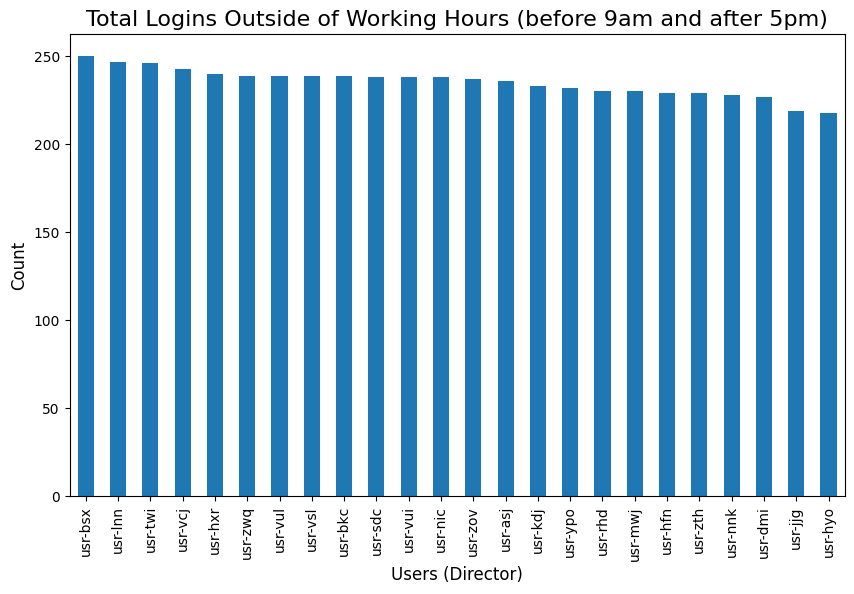

In [7]:
# creating dataframe, count values for total logins and graph for director role
director_login = owh_merged_employee_login[(owh_merged_employee_login["role"]=="Director") & (owh_merged_employee_login["action"]=="login")]
# creating count frame, grouping by user and counting only datetime column to allow for 1d, sorting values descending
director_login_count = director_login.groupby("user")["datetime"].count().sort_values(ascending=False)

# Plotting graph and printing values
print("Average Director Login Count: " + str(director_login_count.mean()))
print("\nTop 5 Highest Login Users:")
print(director_login_count.head())

director_login_count.plot(kind="bar", figsize=(10,6))
plt.title("Total Logins Outside of Working Hours (before 9am and after 5pm)", fontsize=16)
plt.xlabel("Users (Director)", fontsize=12)
plt.ylabel("Count", fontsize=12)

### Director total duration logged in (I.W.H. and O.W.H.)

In [8]:
# Create new dataframe containing both logins and logoffs for director role
director_login_logout = merged_employee_login[merged_employee_login["role"]=="Director"]

# Grouping by user and applying previous function to add logoff times to respective logins
director_login_logout = director_login_logout.groupby("user", group_keys=False).apply(calculate_logoff_datetime)

# Drop all logoff data as all the data needed to plot is contained on each login record
director_logins = director_login_logout[director_login_logout["action"]=="login"]

# Calculate total duration logged in for each session per user
director_logins["duration_logged_total"] = director_logins.apply(lambda x: pd.Timedelta(x.logoff_datetime - x.datetime), axis=1)

# # Convert datetime object to hours so it can be plotted 
director_logins["duration_logged_total"] = director_logins["duration_logged_total"].apply(lambda x: float(x.total_seconds()/3600))

# Calculating time spent logged in outside of work hours
director_logins["duration_logged_owh"] = director_logins.apply(calculate_duration_owh, axis=1)

# Calculating time spent logged in inside work hours (worked out from previous two duration columns)
director_logins["duration_logged_iwh"] = director_logins["duration_logged_total"] - director_logins["duration_logged_owh"]

# creating new dataframe which holds sum of durations total for each user
director_total_duration = pd.DataFrame()
director_total_duration = director_logins.groupby("user")["duration_logged_total"].sum().sort_values(ascending=False)

# creating new dataframe which holds sum of durations o.w.h. for each user
director_total_duration_owh = pd.DataFrame()
director_total_duration_owh = director_logins.groupby("user")["duration_logged_owh"].sum().sort_values(ascending=False)

# creating new dataframe which holds sum of durations i.w.h for each user
director_total_duration_iwh = pd.DataFrame()
director_total_duration_iwh = director_logins.groupby("user")["duration_logged_iwh"].sum().sort_values(ascending=False)

# Printing values for averages and five highest, plotting bar chart for all users
print("\nAverage Duration Total Logged In (hours): " + str(director_total_duration.mean()))

director_logins.head()


Average Duration Total Logged In (hours): 5050.987835648149


,datetime,user,action,pc_x,role,email,pc_y,logoff_datetime,duration_logged_total,duration_logged_owh,duration_logged_iwh
0,2020-01-01 00:21:33,usr-hyo,login,pc205,Director,usr-hyo@onlinebargains.com,pc205,2020-01-01 22:56:43,22.586111,14.586111,8.000000
2,2020-01-02 09:48:15,usr-hyo,login,pc205,Director,usr-hyo@onlinebargains.com,pc205,2020-01-02 23:08:08,13.331389,6.135556,7.195833
4,2020-01-03 05:14:25,usr-hyo,login,pc205,Director,usr-hyo@onlinebargains.com,pc205,2020-01-03 23:46:26,18.533611,10.533611,8.000000
6,2020-01-04 00:33:24,usr-hyo,login,pc205,Director,usr-hyo@onlinebargains.com,pc205,2020-01-04 23:28:16,22.914444,14.914444,8.000000
8,2020-01-05 12:23:24,usr-hyo,login,pc205,Director,usr-hyo@onlinebargains.com,pc205,2020-01-05 20:55:12,8.530000,3.920000,4.610000


### Inside working hours

As seen from the graph length of time logged in for directors barely differs from the average, allowing us to solely use length of time logged in outside working hours to look for any malicious intent.


Director Average Duration I.W.H. Logged In (hours): 2480.303715277778
Director Top 5 Highest Duration I.W.H. Users (hours):
user
usr-bsx    2522.332500
usr-twi    2505.257500
usr-sdc    2499.412222
usr-lnn    2497.754722
usr-bkc    2497.501944
Name: duration_logged_iwh, dtype: float64


Text(0, 0.5, 'Hours')

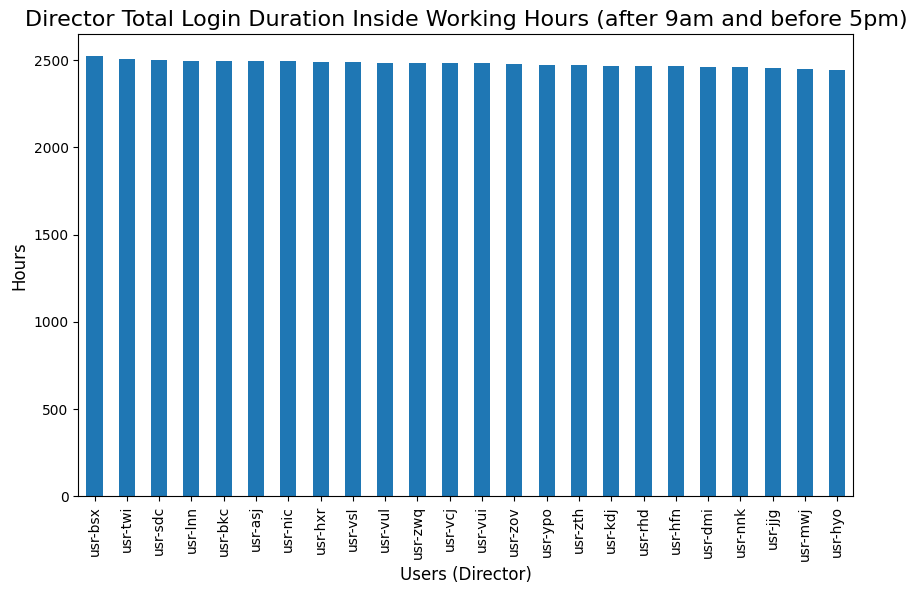

In [9]:
print("\nDirector Average Duration I.W.H. Logged In (hours): " + str(director_total_duration_iwh.mean()))
print("Director Top 5 Highest Duration I.W.H. Users (hours):")
print (director_total_duration_iwh.head())

director_total_duration_iwh.plot(kind="bar", figsize=(10,6))
plt.title("Director Total Login Duration Inside Working Hours (after 9am and before 5pm)", fontsize=16)
plt.xlabel("Users (Director)", fontsize=12)
plt.ylabel("Hours", fontsize=12)

### Outside working hours

As seen in the graph below there is a small difference in time logged in outside work hours between directors. The top three directors, usr-lnn, usr-nic and usr-kdj, logged in for 94, 65 and 60 hours extra respectively.

Although these show a small difference to the average amount of time logged in outside of hours there is not enough evidence to assume any malicious activity here. 

It may be acceptable to assume that directors logging in outside of working hours raises no suspicion as their role being high in the corporate structure warrants 24/7 access to systems.

Other forms of data will need to be investigated to confirm sound intentions throughout all the directors.


Director Average Duration O.W.H. Logged In (hours): 2570.6841203703702
Director Top 5 Highest Duration O.W.H Users (hours):
user
usr-lnn    2664.119444
usr-nic    2635.592500
usr-kdj    2630.107500
usr-zov    2628.317222
usr-vsl    2621.186111
Name: duration_logged_owh, dtype: float64


Text(0, 0.5, 'Hours')

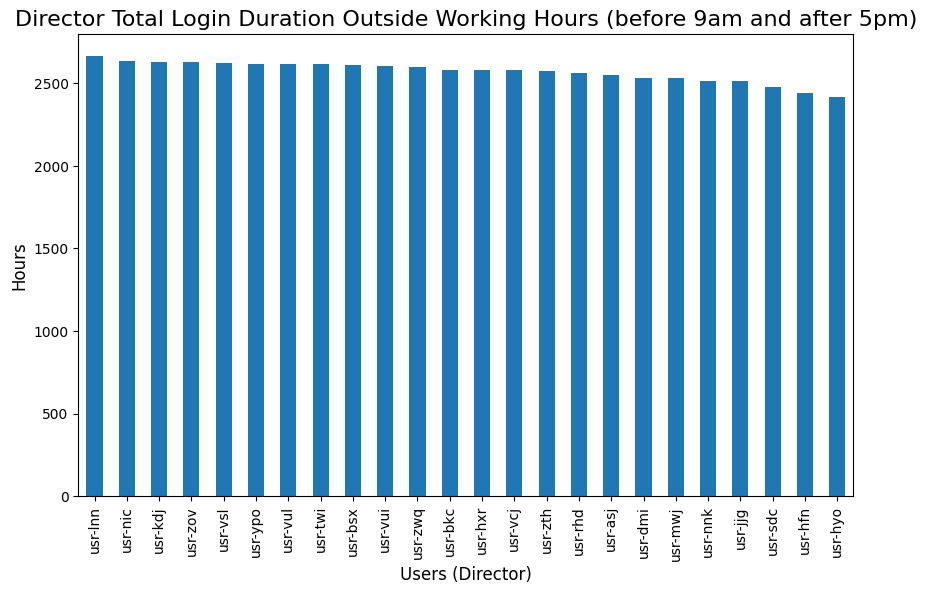

In [10]:
# Printing average and top 5 owh data
print("\nDirector Average Duration O.W.H. Logged In (hours): " + str(director_total_duration_owh.mean()))
print("Director Top 5 Highest Duration O.W.H Users (hours):")
print (director_total_duration_owh.head())

# Plotting owh graph
director_total_duration_owh.plot(kind="bar", figsize=(10,6))
plt.title("Director Total Login Duration Outside Working Hours (before 9am and after 5pm)", fontsize=16)
plt.xlabel("Users (Director)", fontsize=12)
plt.ylabel("Hours", fontsize=12)

## Finance

### Finance total logins outside working hours
Users in the finance role had little difference from the mean in terms of logins outside of work hours.

Average Finance Login Count: 169.1

Top 5 Highest Login Users:
user
usr-utk    183
usr-tiz    182
usr-uyp    181
usr-lhu    181
usr-inp    180
Name: datetime, dtype: int64


Text(0, 0.5, 'Count')

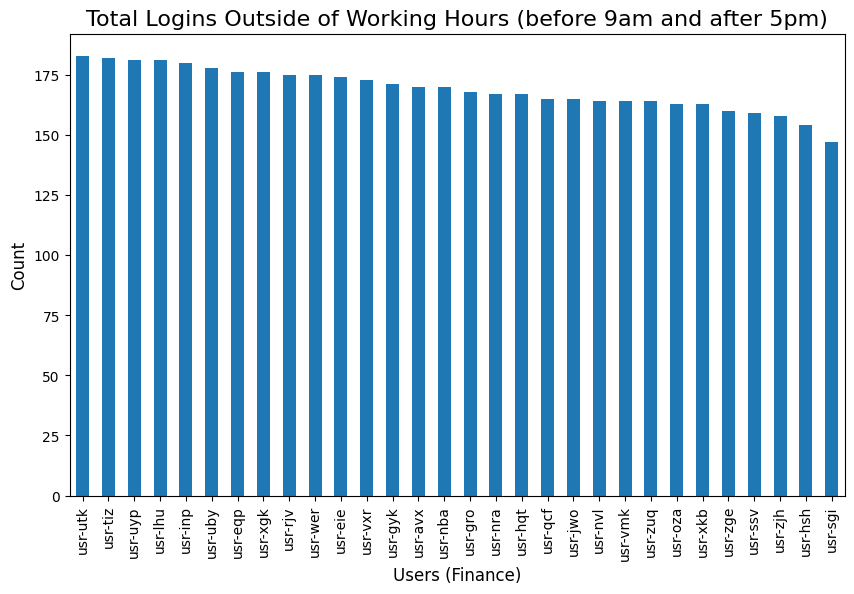

In [11]:
# creating dataframe, count values for total logins and graph for finance role
finance_login = owh_merged_employee_login[(owh_merged_employee_login["role"]=="Finance") & (owh_merged_employee_login["action"]=="login")]
# creating count frame, grouping by user and counting only datetime column to allow for 1d, sorting values descending
finance_login_count = finance_login.groupby("user")["datetime"].count().sort_values(ascending=False)


# Plotting graph and printing values
print("Average Finance Login Count: " + str(finance_login_count.mean()))
print("\nTop 5 Highest Login Users:")
print (finance_login_count.head())

finance_login_count.plot(kind="bar", figsize=(10,6))
plt.title("Total Logins Outside of Working Hours (before 9am and after 5pm)", fontsize=16)
plt.xlabel("Users (Finance)", fontsize=12)
plt.ylabel("Count", fontsize=12)

### Finance total duration logged in (I.W.H. and O.W.H.)

In [12]:
# Create new dataframe containing both logins and logoffs for finance role
finance_login_logout = merged_employee_login[merged_employee_login["role"]=="Finance"]

# Grouping by user and applying previous function to add logoff times to respective logins
finance_login_logout = finance_login_logout.groupby("user", group_keys=False).apply(calculate_logoff_datetime)

# Drop all logoff data as all the data needed to plot is contained on each login record
finance_logins = finance_login_logout[finance_login_logout["action"]=="login"]

# Calculate total duration logged in for each session per user
finance_logins["duration_logged_total"] = finance_logins.apply(lambda x: pd.Timedelta(x.logoff_datetime - x.datetime), axis=1)

# # Convert datetime object to hours so it can be plotted 
finance_logins["duration_logged_total"] = finance_logins["duration_logged_total"].apply(lambda x: float(x.total_seconds()/3600))

# Calculating time spent logged in outside of work hours
finance_logins["duration_logged_owh"] = finance_logins.apply(calculate_duration_owh, axis=1)

# Calculating time spent logged in inside work hours (worked out from previous two duration columns)
finance_logins["duration_logged_iwh"] = finance_logins["duration_logged_total"] - finance_logins["duration_logged_owh"]

# creating new dataframe which holds sum of durations total for each user
finance_total_duration = pd.DataFrame()
finance_total_duration = finance_logins.groupby("user")["duration_logged_total"].sum().sort_values(ascending=False)

# creating new dataframe which holds sum of durations o.w.h. for each user
finance_total_duration_owh = pd.DataFrame()
finance_total_duration_owh = finance_logins.groupby("user")["duration_logged_owh"].sum().sort_values(ascending=False)

# creating new dataframe which holds sum of durations i.w.h for each user
finance_total_duration_iwh = pd.DataFrame()
finance_total_duration_iwh = finance_logins.groupby("user")["duration_logged_iwh"].sum().sort_values(ascending=False)

# Printing values for averages and five highest, plotting bar chart for all users
print("\nAverage Duration Total Logged In (hours): " + str(finance_total_duration.mean()))

finance_logins.head()


Average Duration Total Logged In (hours): 2512.366916666667


,datetime,user,action,pc_x,role,email,pc_y,logoff_datetime,duration_logged_total,duration_logged_owh,duration_logged_iwh
87770,2020-01-01 08:06:15,usr-vxr,login,pc2,Finance,usr-vxr@onlinebargains.com,pc2,2020-01-01 17:08:24,9.035833,1.035833,8.000000
87772,2020-01-02 09:33:51,usr-vxr,login,pc2,Finance,usr-vxr@onlinebargains.com,pc2,2020-01-02 17:51:15,8.290000,0.854167,7.435833
87774,2020-01-03 08:08:54,usr-vxr,login,pc2,Finance,usr-vxr@onlinebargains.com,pc2,2020-01-03 15:37:21,7.474167,0.851667,6.622500
87776,2020-01-04 08:33:21,usr-vxr,login,pc2,Finance,usr-vxr@onlinebargains.com,pc2,2020-01-04 16:18:09,7.746667,0.444167,7.302500
87778,2020-01-05 08:36:02,usr-vxr,login,pc2,Finance,usr-vxr@onlinebargains.com,pc2,2020-01-05 16:40:36,8.076111,0.399444,7.676667


### Inside working hours
Like before total logged in duration inside working hours can be disregarded in the investigation due to all users showing very similar values.


Finance Average Duration I.W.H. Logged In (hours): 2372.552675925926
Finance Top 5 Highest Duration I.W.H. Users (hours):
user
usr-wer    2404.119167
usr-xgk    2395.818056
usr-zjh    2392.315556
usr-tiz    2389.958889
usr-nvl    2388.259167
Name: duration_logged_iwh, dtype: float64


Text(0, 0.5, 'Hours')

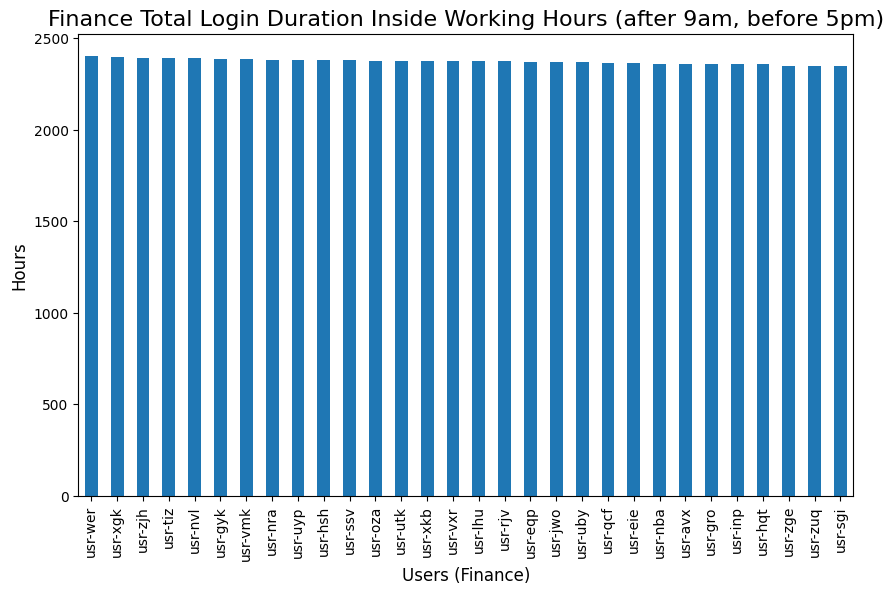

In [13]:
print("\nFinance Average Duration I.W.H. Logged In (hours): " + str(finance_total_duration_iwh.mean()))
print("Finance Top 5 Highest Duration I.W.H. Users (hours):")
print (finance_total_duration_iwh.head())

finance_total_duration_iwh.plot(kind="bar", figsize=(10,6))
plt.title("Finance Total Login Duration Inside Working Hours (after 9am, before 5pm)", fontsize=16)
plt.xlabel("Users (Finance)", fontsize=12)
plt.ylabel("Hours", fontsize=12)

### Outside working hours
Although there is a large disparity in the duration of time logged in outside of work hours, all users are within an acceptable tolerance to the mean level, therefore other data will be needed to confirm no cases of malicious activity.


Finance Average Duration O.W.H. Logged In (hours): 139.81424074074076
Finance Top 5 Highest Duration O.W.H Users (hours):
user
usr-wer    152.872500
usr-avx    149.557500
usr-uyp    148.622222
usr-uby    147.668611
usr-xgk    146.840556
Name: duration_logged_owh, dtype: float64


Text(0, 0.5, 'Hours')

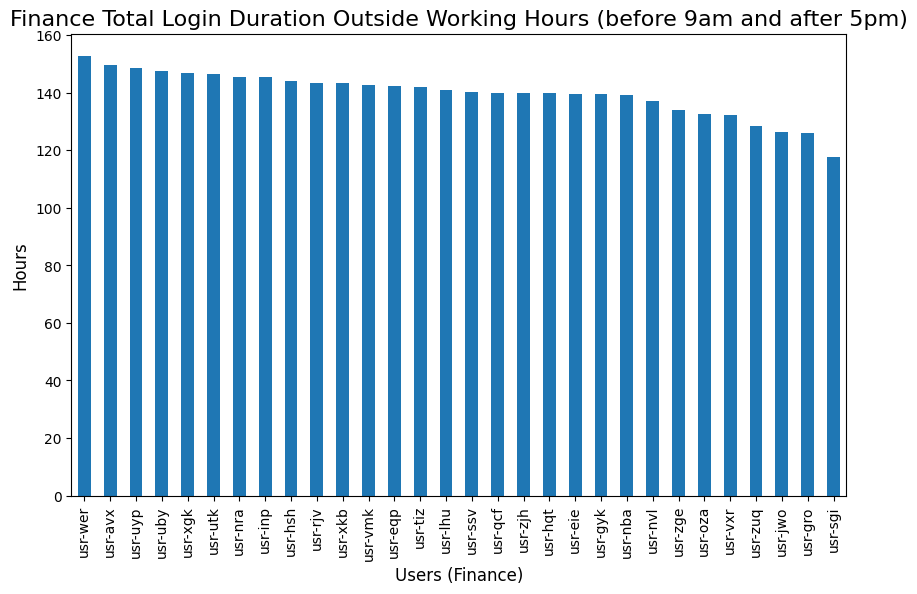

In [14]:
# Printing average and top 5 owh data
print("\nFinance Average Duration O.W.H. Logged In (hours): " + str(finance_total_duration_owh.mean()))
print("Finance Top 5 Highest Duration O.W.H Users (hours):")
print (finance_total_duration_owh.head())

# Plotting owh graph
finance_total_duration_owh.plot(kind="bar", figsize=(10,6))
plt.title("Finance Total Login Duration Outside Working Hours (before 9am and after 5pm)", fontsize=16)
plt.xlabel("Users (Finance)", fontsize=12)
plt.ylabel("Hours", fontsize=12)

## HR

### HR total logins outside working hours
The same conditions that apply to Finance also apply here with all users being within an acceptable tolerance of the mean indicating no malicious activity until other information is reviewed.

Average HR Login Count: 168.0

Top 5 Highest Login Users:
user
usr-uoe    190
usr-zik    184
usr-pmh    180
usr-frc    180
usr-adi    179
Name: datetime, dtype: int64


<AxesSubplot: xlabel='user'>

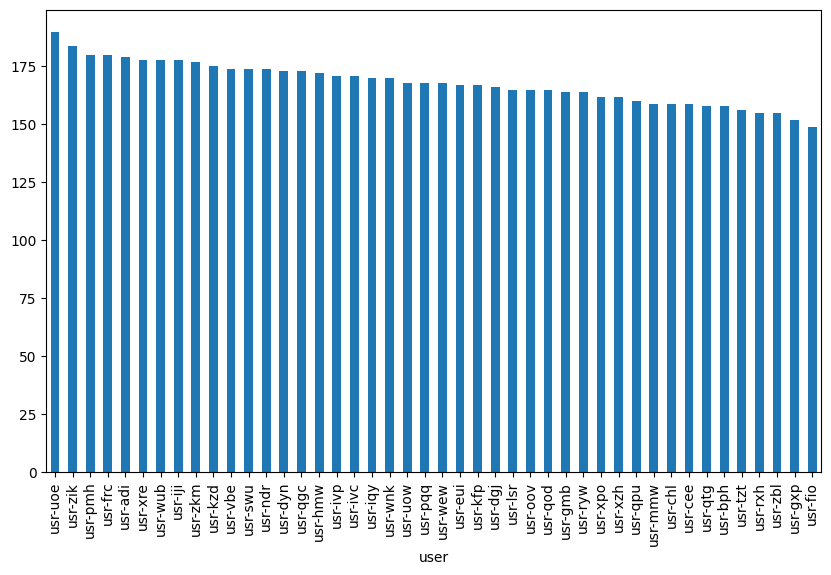

In [15]:
# creating dataframe, count values for total logins and graph for HR role
HR_login = owh_merged_employee_login[(owh_merged_employee_login["role"]=="HR") & (owh_merged_employee_login["action"]=="login")]
# creating count frame, grouping by user and counting only datetime column to allow for 1d, sorting values descending
HR_login_count = HR_login.groupby("user")["datetime"].count().sort_values(ascending=False)

# Plotting graph and printing values
print("Average HR Login Count: " + str(HR_login_count.mean()))
print("\nTop 5 Highest Login Users:")
print (HR_login_count.head())

HR_login_count.plot(kind="bar", figsize=(10,6))

### HR total duration logged in (I.W.H. and O.W.H.)

In [16]:
# Create new dataframe containing both logins and logoffs for HR role
HR_login_logout = merged_employee_login[merged_employee_login["role"]=="HR"]

# Grouping by user and applying previous function to add logoff times to respective logins
HR_login_logout = HR_login_logout.groupby("user", group_keys=False).apply(calculate_logoff_datetime)

# Drop all logoff data as all the data needed to plot is contained on each login record
HR_logins = HR_login_logout[HR_login_logout["action"]=="login"]

# Calculate total duration logged in for each session per user
HR_logins["duration_logged_total"] = HR_logins.apply(lambda x: pd.Timedelta(x.logoff_datetime - x.datetime), axis=1)

# # Convert datetime object to hours so it can be plotted 
HR_logins["duration_logged_total"] = HR_logins["duration_logged_total"].apply(lambda x: float(x.total_seconds()/3600))

# Calculating time spent logged in outside of work hours
HR_logins["duration_logged_owh"] = HR_logins.apply(calculate_duration_owh, axis=1)

# Calculating time spent logged in inside work hours (worked out from previous two duration columns)
HR_logins["duration_logged_iwh"] = HR_logins["duration_logged_total"] - HR_logins["duration_logged_owh"]

# creating new dataframe which holds sum of durations total for each user
HR_total_duration = pd.DataFrame()
HR_total_duration = HR_logins.groupby("user")["duration_logged_total"].sum().sort_values(ascending=False)

# creating new dataframe which holds sum of durations o.w.h. for each user
HR_total_duration_owh = pd.DataFrame()
HR_total_duration_owh = HR_logins.groupby("user")["duration_logged_owh"].sum().sort_values(ascending=False)

# creating new dataframe which holds sum of durations i.w.h for each user
HR_total_duration_iwh = pd.DataFrame()
HR_total_duration_iwh = HR_logins.groupby("user")["duration_logged_iwh"].sum().sort_values(ascending=False)

# Printing values for averages and five highest, plotting bar chart for all users
print("\nAverage Duration Total Logged In (hours): " + str(HR_total_duration.mean()))

HR_logins.head()


Average Duration Total Logged In (hours): 2510.7022853535354


,datetime,user,action,pc_x,role,email,pc_y,logoff_datetime,duration_logged_total,duration_logged_owh,duration_logged_iwh
87100,2020-01-01 08:05:24,usr-gxp,login,pc221,HR,usr-gxp@onlinebargains.com,pc221,2020-01-01 17:17:30,9.201667,1.201667,8.000000
87102,2020-01-02 08:07:27,usr-gxp,login,pc221,HR,usr-gxp@onlinebargains.com,pc221,2020-01-02 17:50:15,9.713333,1.713333,8.000000
87104,2020-01-03 08:51:47,usr-gxp,login,pc221,HR,usr-gxp@onlinebargains.com,pc221,2020-01-03 15:22:26,6.510833,0.136944,6.373889
87106,2020-01-04 08:25:23,usr-gxp,login,pc221,HR,usr-gxp@onlinebargains.com,pc221,2020-01-04 17:57:27,9.534444,1.534444,8.000000
87108,2020-01-05 08:33:21,usr-gxp,login,pc221,HR,usr-gxp@onlinebargains.com,pc221,2020-01-05 15:28:48,6.924167,0.444167,6.480000


### Inside working hours

All users are logged in for similar amounts of time allowing us to base our investigation on duration logged in outside of work hours.


HR Average Duration I.W.H. Logged In (hours): 2370.1267171717172
HR Top 5 Highest Duration I.W.H. Users (hours):
user
usr-chl    2394.052500
usr-zik    2391.798056
usr-uow    2382.946111
usr-wnk    2382.279444
usr-dyn    2379.217778
Name: duration_logged_iwh, dtype: float64


Text(0, 0.5, 'Hours')

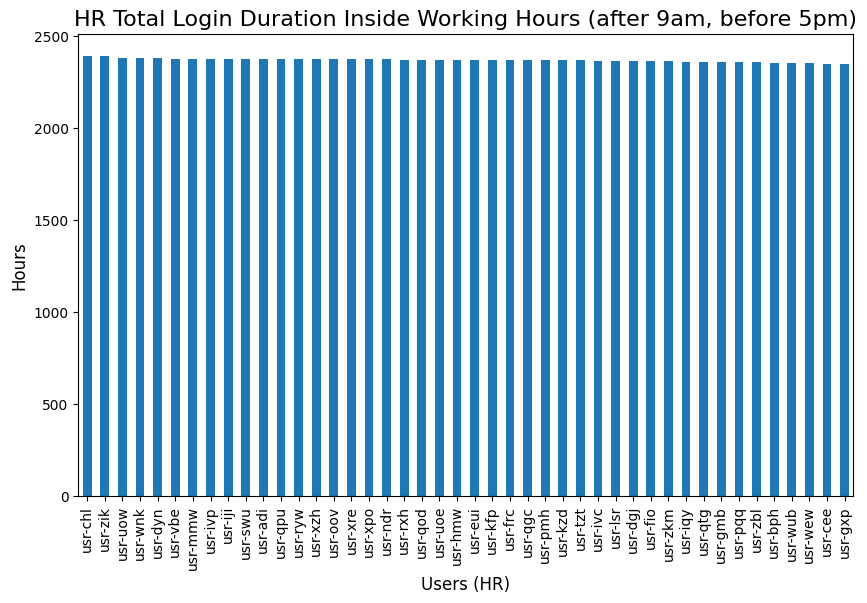

In [17]:
print("\nHR Average Duration I.W.H. Logged In (hours): " + str(HR_total_duration_iwh.mean()))
print("HR Top 5 Highest Duration I.W.H. Users (hours):")
print (HR_total_duration_iwh.head())

HR_total_duration_iwh.plot(kind="bar", figsize=(10,6))
plt.title("HR Total Login Duration Inside Working Hours (after 9am, before 5pm)", fontsize=16)
plt.xlabel("Users (HR)", fontsize=12)
plt.ylabel("Hours", fontsize=12)

### Outside working hours
Other information will be required to show malicious intent here as all users are within acceptable ranges of the mean values.


HR Average Duration O.W.H. Logged In (hours): 140.57556818181817
HR Top 5 Highest Duration O.W.H Users (hours):
user
usr-frc    152.239722
usr-dgj    150.883611
usr-vbe    150.726111
usr-ryw    150.131389
usr-hmw    149.832778
Name: duration_logged_owh, dtype: float64


Text(0, 0.5, 'Hours')

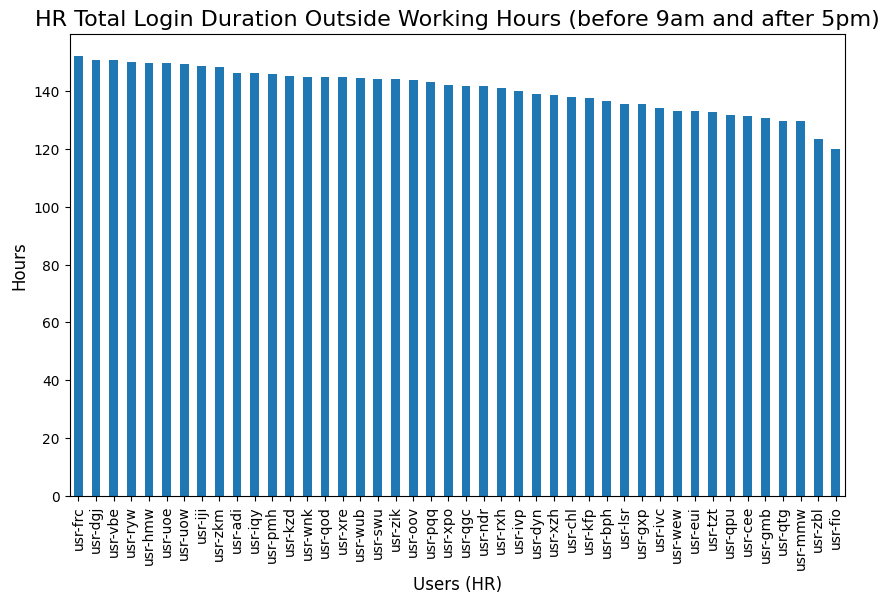

In [18]:
# Printing average and top 5 owh data
print("\nHR Average Duration O.W.H. Logged In (hours): " + str(HR_total_duration_owh.mean()))
print("HR Top 5 Highest Duration O.W.H Users (hours):")
print (HR_total_duration_owh.head())

# Plotting owh graph
HR_total_duration_owh.plot(kind="bar", figsize=(10,6))
plt.title("HR Total Login Duration Outside Working Hours (before 9am and after 5pm)", fontsize=16)
plt.xlabel("Users (HR)", fontsize=12)
plt.ylabel("Hours", fontsize=12)

## Technical/Security/Services + Legal

### Total logins outside of work hours

Technical, Security and Services roles showed very strange behaviour. Every user account in allocated to each of these roles showed the exact same amount of logins, out of hours, with this number being 335. As there are a different amount of users assigned to each of these roles we can investigate the logins in more depth by taking into account time logged in. Just like the other roles above I have calculated time logged in out of working hours, inside working hours and in total to give us a better insight into the data, this can be seen below:

The Legal role showed no logins outside of working hours and therefore reflects no suspicious behaviour, meaning a different approach will be needed to detect malicious activity from this role.

In [19]:
# creating dataframe, count values for total logins and graph for technical role
technical_login = owh_merged_employee_login[(owh_merged_employee_login["role"]=="Technical") & (owh_merged_employee_login["action"]=="login")]
technical_login_count = technical_login.groupby("user")["datetime"].count()

print("Logins - Technical: "+str(technical_login_count.unique())) # unique function used to show how many different values for amount of times logged in 

# creating dataframe, count values for total logins and graph for security role
security_login = owh_merged_employee_login[(owh_merged_employee_login["role"]=="Security") & (owh_merged_employee_login["action"]=="login")]
security_login_count = security_login.groupby("user")["datetime"].count()

print("\nLogins - Security: "+str(security_login_count.unique())) # unique function used to show how many different values for amount of times logged in

# creating dataframe, count values for total logins and graph for services role
services_login = owh_merged_employee_login[(owh_merged_employee_login["role"]=="Services") & (owh_merged_employee_login["action"]=="login")]
services_login_count = services_login.groupby("user")["datetime"].count()

print("\nLogins - Services: "+str(services_login_count.unique())) # unique function used to show how many different values for amount of times logged in

# creating dataframe, count values for total logins and graph for legal role
legal_login = owh_merged_employee_login[(owh_merged_employee_login["role"]=="Legal") & (owh_merged_employee_login["action"]=="login")]
legal_login_count = legal_login.groupby("user")["datetime"].count()

print("\nLogins - Legal: "+str(legal_login_count.unique())) # unique used to show 0 logins outside of work hours

Logins - Technical: [335]

Logins - Security: [335]

Logins - Services: [335]

Logins - Legal: []


### Technical/Security/Services/Legal total duration logged in (I.W.H. and O.W.H.)
The following code is used to create a number of different dataframes holding login duration data for all four of these roles.

Users allocated to the technical role show an extreme amount of time logged into the system, even more than the directors average. This in itself does not imply anything malicious but may be something to note and refer back to after more data is reviewed.

In [20]:
# TECHNICAL ROLE ###############################################################################################
# Create new dataframe containing both logins and logoffs for technical role
technical_login_logout = merged_employee_login[merged_employee_login["role"]=="Technical"]

# Grouping by user and applying previous function to add logoff times to respective logins
technical_login_logout = technical_login_logout.groupby("user", group_keys=False).apply(calculate_logoff_datetime)

# Drop all logoff data as all the data needed to plot is contained on each login record
technical_logins = technical_login_logout[technical_login_logout["action"]=="login"]

# Calculate total duration logged in for each session per user
technical_logins["duration_logged_total"] = technical_logins.apply(lambda x: pd.Timedelta(x.logoff_datetime - x.datetime), axis=1)

# # Convert datetime object to hours so it can be plotted 
technical_logins["duration_logged_total"] = technical_logins["duration_logged_total"].apply(lambda x: float(x.total_seconds()/3600))

# Calculating time spent logged in outside of work hours
technical_logins["duration_logged_owh"] = technical_logins.apply(calculate_duration_owh, axis=1)

# Calculating time spent logged in inside work hours (worked out from previous two duration columns)
technical_logins["duration_logged_iwh"] = technical_logins["duration_logged_total"] - technical_logins["duration_logged_owh"]

# creating new dataframe which holds sum of durations total for each user
technical_total_duration = pd.DataFrame()
technical_total_duration = technical_logins.groupby("user")["duration_logged_total"].sum().sort_values(ascending=False)

# creating new dataframe which holds sum of durations o.w.h. for each user
technical_total_duration_owh = pd.DataFrame()
technical_total_duration_owh = technical_logins.groupby("user")["duration_logged_owh"].sum().sort_values(ascending=False)

# creating new dataframe which holds sum of durations i.w.h for each user
technical_total_duration_iwh = pd.DataFrame()
technical_total_duration_iwh = technical_logins.groupby("user")["duration_logged_iwh"].sum().sort_values(ascending=False)

# Printing values for averages and five highest, plotting bar chart for all users
print("\nTechnical Average Duration Total Logged In (hours): " + str(technical_total_duration.mean()))

# SECURITY ROLE ###############################################################################################
# Create new dataframe containing both logins and logoffs for technical role
security_login_logout = merged_employee_login[merged_employee_login["role"]=="Security"]

# Grouping by user and applying previous function to add logoff times to respective logins
security_login_logout = security_login_logout.groupby("user", group_keys=False).apply(calculate_logoff_datetime)

# Drop all logoff data as all the data needed to plot is contained on each login record
security_logins = security_login_logout[security_login_logout["action"]=="login"]

# Calculate total duration logged in for each session per user
security_logins["duration_logged_total"] = security_logins.apply(lambda x: pd.Timedelta(x.logoff_datetime - x.datetime), axis=1)

# # Convert datetime object to hours so it can be plotted 
security_logins["duration_logged_total"] = security_logins["duration_logged_total"].apply(lambda x: float(x.total_seconds()/3600))

# Calculating time spent logged in outside of work hours
security_logins["duration_logged_owh"] = security_logins.apply(calculate_duration_owh, axis=1)

# Calculating time spent logged in inside work hours (worked out from previous two duration columns)
security_logins["duration_logged_iwh"] = security_logins["duration_logged_total"] - security_logins["duration_logged_owh"]

# creating new dataframe which holds sum of durations total for each user
security_total_duration = pd.DataFrame()
security_total_duration = security_logins.groupby("user")["duration_logged_total"].sum().sort_values(ascending=False)

# creating new dataframe which holds sum of durations o.w.h. for each user
security_total_duration_owh = pd.DataFrame()
security_total_duration_owh = security_logins.groupby("user")["duration_logged_owh"].sum().sort_values(ascending=False)

# creating new dataframe which holds sum of durations i.w.h for each user
security_total_duration_iwh = pd.DataFrame()
security_total_duration_iwh = security_logins.groupby("user")["duration_logged_iwh"].sum().sort_values(ascending=False)

# Printing values for averages and five highest, plotting bar chart for all users
print("\nSecurity Average Duration Total Logged In (hours): " + str(security_total_duration.mean()))


# SERVICES ROLE ###############################################################################################
# Create new dataframe containing both logins and logoffs for technical role
services_login_logout = merged_employee_login[merged_employee_login["role"]=="Services"]

# Grouping by user and applying previous function to add logoff times to respective logins
services_login_logout = services_login_logout.groupby("user", group_keys=False).apply(calculate_logoff_datetime)

# Drop all logoff data as all the data needed to plot is contained on each login record
services_logins = services_login_logout[services_login_logout["action"]=="login"]

# Calculate total duration logged in for each session per user
services_logins["duration_logged_total"] = services_logins.apply(lambda x: pd.Timedelta(x.logoff_datetime - x.datetime), axis=1)

# # Convert datetime object to hours so it can be plotted 
services_logins["duration_logged_total"] = services_logins["duration_logged_total"].apply(lambda x: float(x.total_seconds()/3600))

# Calculating time spent logged in outside of work hours
services_logins["duration_logged_owh"] = services_logins.apply(calculate_duration_owh, axis=1)

# Calculating time spent logged in inside work hours (worked out from previous two duration columns)
services_logins["duration_logged_iwh"] = services_logins["duration_logged_total"] - services_logins["duration_logged_owh"]

# creating new dataframe which holds sum of durations total for each user
services_total_duration = pd.DataFrame()
services_total_duration = services_logins.groupby("user")["duration_logged_total"].sum().sort_values(ascending=False)

# creating new dataframe which holds sum of durations o.w.h. for each user
services_total_duration_owh = pd.DataFrame()
services_total_duration_owh = services_logins.groupby("user")["duration_logged_owh"].sum().sort_values(ascending=False)

# creating new dataframe which holds sum of durations i.w.h for each user
services_total_duration_iwh = pd.DataFrame()
services_total_duration_iwh = services_logins.groupby("user")["duration_logged_iwh"].sum().sort_values(ascending=False)

# Printing values for averages and five highest, plotting bar chart for all users
print("\nServices Average Duration Total Logged In (hours): " + str(services_total_duration.mean()))


# LEGAL ROLE ###############################################################################################
# Create new dataframe containing both logins and logoffs for technical role
legal_login_logout = merged_employee_login[merged_employee_login["role"]=="Legal"]

# Grouping by user and applying previous function to add logoff times to respective logins
legal_login_logout = legal_login_logout.groupby("user", group_keys=False).apply(calculate_logoff_datetime)

# Drop all logoff data as all the data needed to plot is contained on each login record
legal_logins = legal_login_logout[legal_login_logout["action"]=="login"]

# Calculate total duration logged in for each session per user
legal_logins["duration_logged_total"] = legal_logins.apply(lambda x: pd.Timedelta(x.logoff_datetime - x.datetime), axis=1)

# # Convert datetime object to hours so it can be plotted 
legal_logins["duration_logged_total"] = legal_logins["duration_logged_total"].apply(lambda x: float(x.total_seconds()/3600))

# Calculating time spent logged in outside of work hours
legal_logins["duration_logged_owh"] = legal_logins.apply(calculate_duration_owh, axis=1)

# Calculating time spent logged in inside work hours (worked out from previous two duration columns)
legal_logins["duration_logged_iwh"] = legal_logins["duration_logged_total"] - legal_logins["duration_logged_owh"]

# creating new dataframe which holds sum of durations total for each user
legal_total_duration = pd.DataFrame()
legal_total_duration = legal_logins.groupby("user")["duration_logged_total"].sum().sort_values(ascending=False)

# creating new dataframe which holds sum of durations o.w.h. for each user
legal_total_duration_owh = pd.DataFrame()
legal_total_duration_owh = legal_logins.groupby("user")["duration_logged_owh"].sum().sort_values(ascending=False)

# creating new dataframe which holds sum of durations i.w.h for each user
legal_total_duration_iwh = pd.DataFrame()
legal_total_duration_iwh = legal_logins.groupby("user")["duration_logged_iwh"].sum().sort_values(ascending=False)

# Printing values for averages and five highest, plotting bar chart for all users
print("\nLegal Average Duration Total Logged In (hours): " + str(legal_total_duration.mean()))


Technical Average Duration Total Logged In (hours): 5197.518663194445

Security Average Duration Total Logged In (hours): 5024.018922558923

Services Average Duration Total Logged In (hours): 4016.4017573696146

Legal Average Duration Total Logged In (hours): 2512.8511561561563


### Inside working hours
As seen from the graphs below for each of these four roles, there are no serious outliers, meaning all users had similar total durations of logged time inside working hours.

Assumptions made about the services role could state that it includes staff such as cleaners. Usually staff of this would come into work out of hours and would see much use within standard working hours. Duration logged in inside working hours for this role seems extremely excessive as it is higher than that of the directors and security, 2480 and 2529 respectively. Legal and Technical roles do have a higher duration logged in but this is expected. Techincal support staff will always be logged in for a long duration. Legal staff have very little time logged in out of hours meaning they conduct most of their business inside standard working hours, meaning this high duration is also expected.

Service staff spending a duration of time logged in, inside working hours, with a magnitude of this should definetly suggest suspicious activity. As this suspicion is based on an average value then it must be directed at the whole department. An accusation of this scale needs more supporting data in order for it to definite.

In [21]:
# Printing average times logged in inside working hours for all four roles of section

print("\nTechnical Average Duration I.W.H. Logged In (hours): " + str(technical_total_duration_iwh.mean()))
print("\nSecurity Average Duration I.W.H. Logged In (hours): " + str(security_total_duration_iwh.mean()))
print("\nServices Average Duration I.W.H. Logged In (hours): " + str(services_total_duration_iwh.mean()))
print("\nLegal Average Duration I.W.H. Logged In (hours): " + str(legal_total_duration_iwh.mean()))


Technical Average Duration I.W.H. Logged In (hours): 2680.0

Security Average Duration I.W.H. Logged In (hours): 2529.1869191919186

Services Average Duration I.W.H. Logged In (hours): 2543.749155328798

Legal Average Duration I.W.H. Logged In (hours): 2345.5409609609615


Text(0, 0.5, 'Duration(hours')

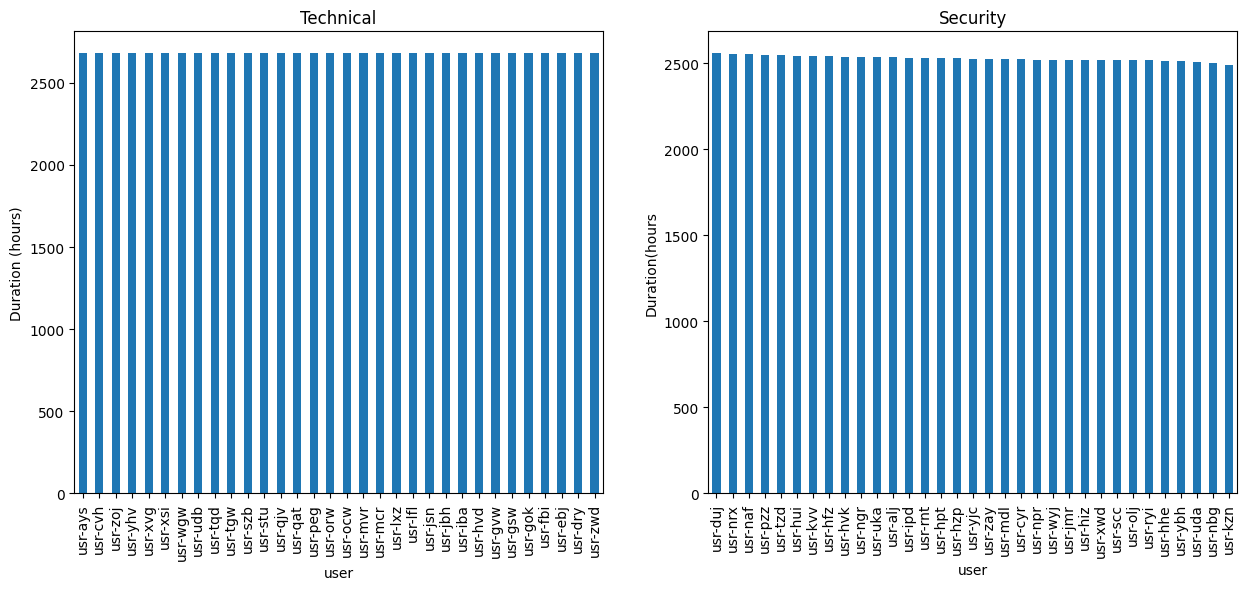

In [22]:
fig, axs = plt.subplots(1, 2)

technical_total_duration_iwh.plot(kind="bar", figsize=(15,6), ax=axs[0])
axs[0].set_title("Technical")
axs[0].set_ylabel("Duration (hours)", fontsize=10)

security_total_duration_iwh.plot(kind="bar", figsize=(15,6), ax=axs[1])
axs[1].set_title("Security")
axs[1].set_ylabel("Duration(hours", fontsize=10)

Text(0, 0.5, 'Duration(hours')

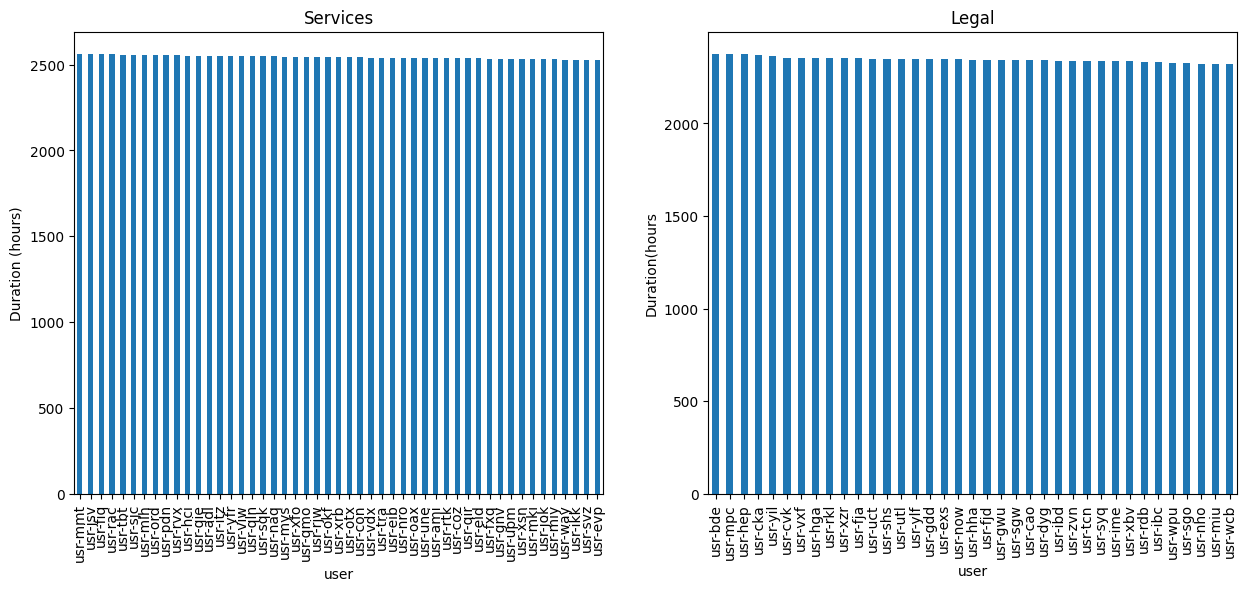

In [23]:
fig, axs = plt.subplots(1, 2)

services_total_duration_iwh.plot(kind="bar", figsize=(15,6), ax=axs[0])
axs[0].set_title("Services")
axs[0].set_ylabel("Duration (hours)", fontsize=10)

legal_total_duration_iwh.plot(kind="bar", figsize=(15,6), ax=axs[1])
axs[1].set_title("Legal")
axs[1].set_ylabel("Duration(hours", fontsize=10)

### Outside working hours
Technical and Security roles have a very large amount of time logged in outside of working hours and should therefore be investigated further.
The highest duration o.w.h. user in the security sector does outlie from the data slightly and should be made note of. The user "usr-hui" had 117 more hours logged than the average which is greatly above the mean value.

Users from the services role conduct most of their business out of hours so this data could be viewed as normal. Although, for their role, services staff are logged in for a very large duration given their job not requiring extensive use of computer systems.

Users from the legal role had very little o.w.h. logged in duration relative to the other roles and therefore other data will be needed to investigate this role.


Technical Average Duration O.W.H. Logged In (hours): 2517.5186631944443
Technical Top 5 Highest Duration O.W.H. Users (hours):
user
usr-iba    2583.262222
usr-cvh    2563.523333
usr-szb    2551.919722
usr-orw    2546.035000
usr-ebj    2545.393889
Name: duration_logged_owh, dtype: float64

Security Average Duration O.W.H. Logged In (hours): 2494.8320033670034
Security Top 5 Highest Duration O.W.H. Users (hours):
user
usr-hui    2611.964722
usr-pzz    2581.806944
usr-uka    2566.520278
usr-tzd    2563.136389
usr-hhe    2562.872500
Name: duration_logged_owh, dtype: float64


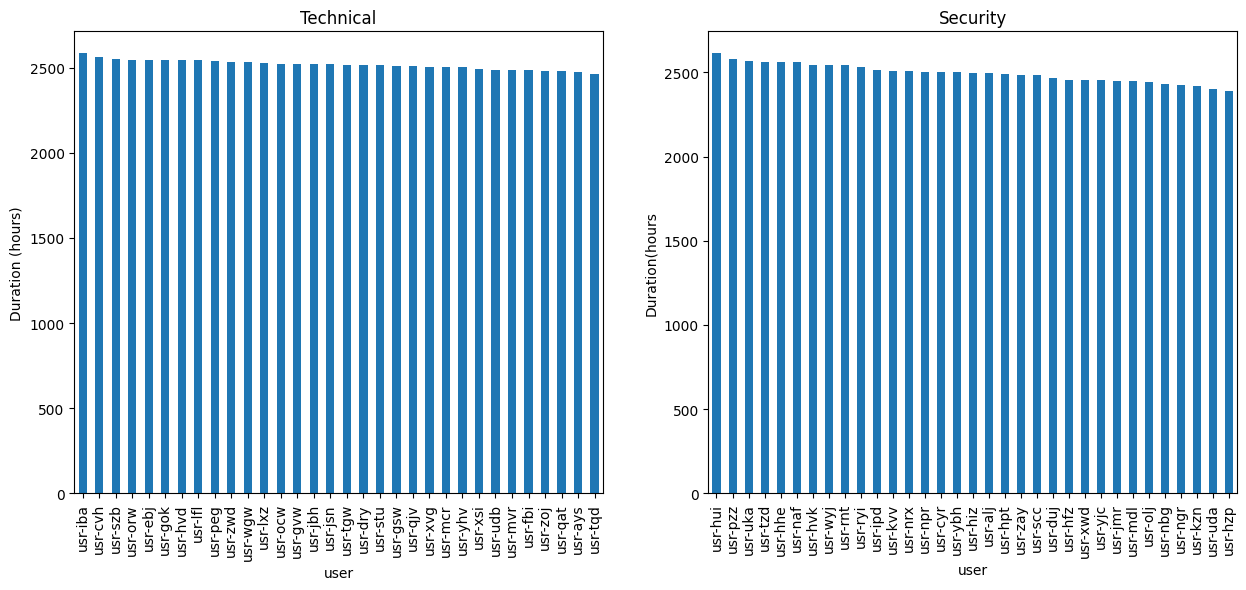

In [24]:
fig, axs = plt.subplots(1, 2)

technical_total_duration_owh.plot(kind="bar", figsize=(15,6), ax=axs[0])
axs[0].set_title("Technical")
axs[0].set_ylabel("Duration (hours)", fontsize=10)

print("\nTechnical Average Duration O.W.H. Logged In (hours): " + str(technical_total_duration_owh.mean()))
print("Technical Top 5 Highest Duration O.W.H. Users (hours):")
print (technical_total_duration_owh.head())

security_total_duration_owh.plot(kind="bar", figsize=(15,6), ax=axs[1])
axs[1].set_title("Security")
axs[1].set_ylabel("Duration(hours", fontsize=10)

print("\nSecurity Average Duration O.W.H. Logged In (hours): " + str(security_total_duration_owh.mean()))
print("Security Top 5 Highest Duration O.W.H. Users (hours):")
print (security_total_duration_owh.head())


Services Average Duration O.W.H. Logged In (hours): 1472.6526020408162
Services Top 5 Highest Duration O.W.H. Users (hours):
user
usr-mmt    1532.622778
usr-jsv    1524.617222
usr-xfo    1512.245278
usr-qie    1510.123889
usr-ord    1508.181111
Name: duration_logged_owh, dtype: float64

Legal Average Duration O.W.H. Logged In (hours): 167.31019519519518
Legal Top 5 Highest Duration O.W.H. Users (hours):
user
usr-hga    186.691389
usr-bde    186.082500
usr-cvk    184.281111
usr-sgw    180.317222
usr-xbv    179.670278
Name: duration_logged_owh, dtype: float64


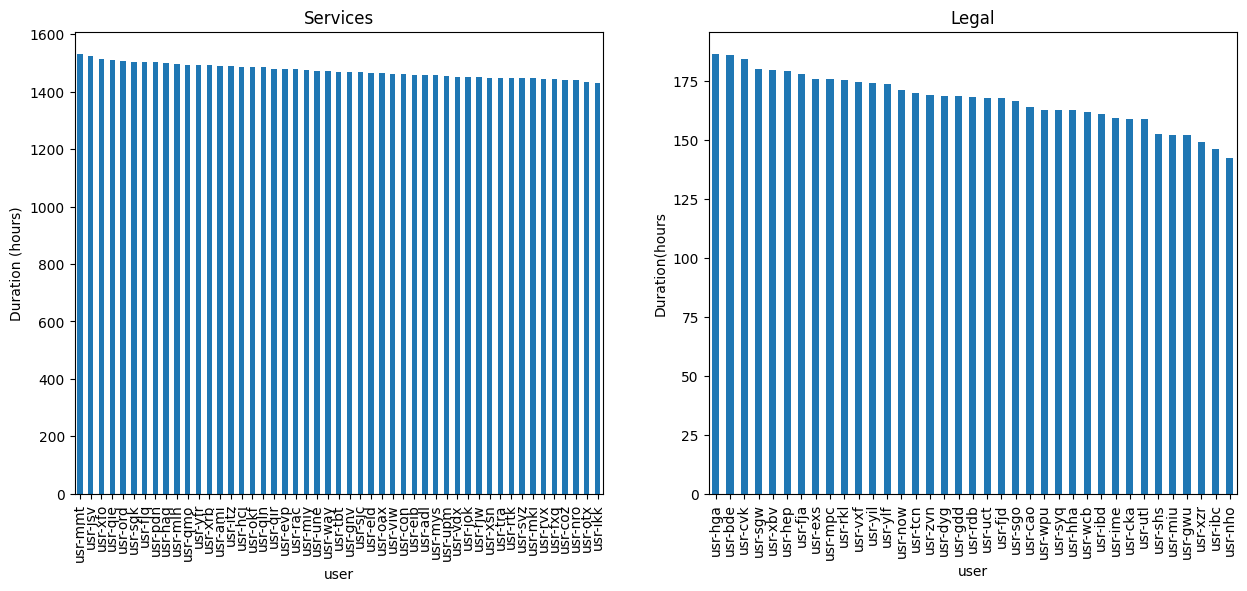

In [25]:
fig, axs = plt.subplots(1, 2)

services_total_duration_owh.plot(kind="bar", figsize=(15,6), ax=axs[0])
axs[0].set_title("Services")
axs[0].set_ylabel("Duration (hours)", fontsize=10)

print("\nServices Average Duration O.W.H. Logged In (hours): " + str(services_total_duration_owh.mean()))
print("Services Top 5 Highest Duration O.W.H. Users (hours):")
print(services_total_duration_owh.head())

legal_total_duration_owh.plot(kind="bar", figsize=(15,6), ax=axs[1])
axs[1].set_title("Legal")
axs[1].set_ylabel("Duration(hours", fontsize=10)

print("\nLegal Average Duration O.W.H. Logged In (hours): " + str(legal_total_duration_owh.mean()))
print("Legal Top 5 Highest Duration O.W.H. Users (hours):")
print(legal_total_duration_owh.head())

## Logins from different PCs
The employee data file implies that each user has a specific pc assigned to them. Using this information logins can be checked against a users allocated PC to see which users have logged in using a different users PC. Checking this data may help to find malicious activity as a user with ill intentions may use a different pc to the one they are allocated as a way of "covering their tracks".

Shown from the code below, no users logged into a pc that wasnt pre-allocated to them. PC allocation will be explored further in the next section of the investigation.

In [26]:
# Print amount of mismatched allocations of pc to login pc for all users
print(len(merged_employee_login[merged_employee_login["pc_x"]!=merged_employee_login["pc_y"]]))

0


# Investigating USB and File Data
In this section the investigation moves onto looking at malicious intent regarding hardware and files. This section will first define what could be regarded as a "high-risk" file, after this is done data can be checked to see which users have accessed these files. Malicious intent can be assumed if a users USB was inserted at the same time this file was accessed. More below.

The code cell below is used to start to create a list of possible high-risk files that should be investigated further.

Although this section will investigate potential unauthorised access to files it will also focus on whether or not a USB device was insertted at the time the file was accessed. One of the largest problems that the organisation may face is the risk of data leaks. USB devices and High-Risk files being used or accessed concurrently posses a massive risk of data leaks and therefore should be the main focus of this section of the investigation.

**Please note that directors would usually have access to all files within the company and therefore they can be excluded from role specific investigations. E.g. no suspicion can feasibly be raised from a director accessing a file that is only meant for technical staff.**

In [27]:
file_data["filename"].value_counts()

/misc                   238429
/docs/committee         238354
/docs                   238317
/do_not_delete          238061
/company_profile        237677
/system/general         237653
/newsletter/general     237461
/policy                 237414
/docs/general           237388
/secret                 237211
/docs/social            237198
/newsletter             236988
/tech                   105736
/dev                     96774
/docs/clients            93807
/docs/employment         84154
/private                 84114
/system                  78776
/docs/ip                 76037
/security                60204
/FYEO                    55103
/system/source           48127
/security/ids            47932
/backups                 47929
/system/site             30116
/private/staffreview     26923
/security/physical       11387
Name: filename, dtype: int64

## Defining file types
The following section is split into 3 different categories: System/Technical Files, Security Files and High-Risk Files. Each section states which files are involved in its respective investigation and the reasoning behind why certain behaviours are suspicious.

### System/Technical Files
This section contains files which may contain system data or are of use to those of the technical role.
 
These files should regularly be accessed by technical staff but not regularly by the rest of the organisation.

System files include (inc. small description of possible data):

 - "/system/general"    - will contain general files such as program files, may contain personal settings data for allocated pcs.
 - "/tech"              - may contain information only usable by those of the technical role.
 - "/dev"               - high-risk technical file, contains developement resources. Explicitly used by technical roles.
 - "/system"            - also could contain more general data, little need to access.
 - "/system/source"     - contains source files, should only be accessed by technical staff, no reason for general access to other roles.
 - "/system/site"       - unclear what data is contained here, due to low access number is not important to roles other than technical.

These files are ordered by access count. With the top being accessed most frequently and bottom the least.

### Security Files
This section contains files which are used by members of the security team, there is little need for those of other roles to access these files.

Security files include (inc. small description of possible data):
 - "/security"          - may contain general data used by security personel.
 - "/security/ids"      - contains identification details for all staff members, no need for general access.
 - "/security/physical  - may contain data about physical access such as door codes, only security role needs access.

These files are ordered by access count. With the top being accessed most frequently and bottom the least. Please note that all of these files are accessed relatively seldom compared to others.

### High-Risk Files
This section will combine some files from the previous two sections along with some new ones to create a list of files that could be considered high-risk.

High-Risk files:
 - "/secret"                - clearly contains some sort of data that isn't intended for general access.
 - "/docs/clients"          - contains important documents on clients, very high-risk to leaks.
 - "/docs/employment"       - contains important documents on employees, very high-risk to leaks.
 - "/private"               - contains private files, possibly similar to secret file system.
 - "/FYEO"                  - may mean: "for your eyes only", similar to private and secret, not for general access.
 - "/system/source"         - system source file, absolutely no access outside of tech roles.
 - "/private/staffreview"   - contains details about staff, access only needed by directors.
 - "/security/physical"     - physical security data, very high-risk to leaks.

 

In [28]:
# Create array of high risk files from all 3 sections defined above
high_risk_files = ["/secret",\
                    "/dev",\
                    "/docs/clients",\
                    "/docs/employment",\
                    "/private",\
                    "/security",\
                    "/FYEO",\
                    "/system/source",\
                    "/security/ids",\
                    "/private/staffreview",\
                    "/security/physical"]

## Processing USB data
The algorithm used in the login data section can be repurposed to process file data. The following code cell creates a new dataframe containing the insert and corresponding removal of each usb device on a singular record. This makes it easier to check if a USB device was inserted when unauthorised access was gained to a file.

In [29]:
# function to shift all datetimes up to give us corresponding removal as data is chronological
def calculate_removal_datetime(x):
    x["removal_datetime"] = x["datetime"].shift(-1)
    return x

# creating new dataframes and adding new column that holds removal datetime for each insert
usb_data_wr = usb_data.groupby("user", group_keys=False).apply(calculate_removal_datetime)

# dropping all removal records as datetime is stored with insert
usb_data_wr = usb_data_wr[usb_data_wr["action"]=="usb_insert"]

usb_data_wr

,datetime,user,action,pc,removal_datetime
0,2020-01-01 04:34:12.544490,usr-mcr,usb_insert,pc13,2020-01-01 04:58:24.927262
1,2020-01-01 04:38:24.821774,usr-udb,usb_insert,pc66,2020-01-01 05:04:31.167712
2,2020-01-01 04:40:59.860587,usr-con,usb_insert,pc146,2020-01-01 04:49:48.424349
3,2020-01-01 04:45:49.701116,usr-xsn,usb_insert,pc30,2020-01-01 05:13:43.852731
4,2020-01-01 04:49:10.958272,usr-rjw,usb_insert,pc226,2020-01-01 05:02:25.672964
...,...,...,...,...,...
460697,2020-11-30 21:04:39.045862,usr-wgw,usb_insert,pc53,2020-11-30 21:08:33.295969
460702,2020-11-30 21:16:09.259054,usr-fbi,usb_insert,pc177,2020-11-30 22:05:32.796175
460703,2020-11-30 21:17:55.544438,usr-cvh,usb_insert,pc83,2020-11-30 21:45:09.830831
460707,2020-11-30 21:52:23.963103,usr-ebj,usb_insert,pc107,2020-11-30 21:59:12.697110


## Investigating file access per role
In this section access to the various different file types above will be investigated. Starting on system/technical files. These files are thought to contain data that is mainly of interest to those of the technical role, therefore access from other roles would be cause for concern. Some situations may require another role to access these files however it should only be for a brief time.

The next code cell creates a new merged dataframe from employee_data and file_data so that role can be references in this part of the investigation.

**From previous investigations, suspicions are raised for all staff in the services department meaning they will investigated in depth in this section.*

In [30]:
# Merged employee_data and file_data so role can be referenced from file
mef = pd.merge(file_data, employee_data, on="user")

# creating new dataframe containing only high-risk files
highrisk_merged_employee_file = mef[mef["filename"].isin(high_risk_files)]

### Director
The director role is quite difficult to detect suspicious behaviour in, especially in terms of file access. This is due to the fact that all users in this role probably have access to all files. The following pie chart doesnt suggest anything suspicious as all the files accessed would normally be access by directors.

Text(0.5, 1.0, 'Director access to high-risk files')

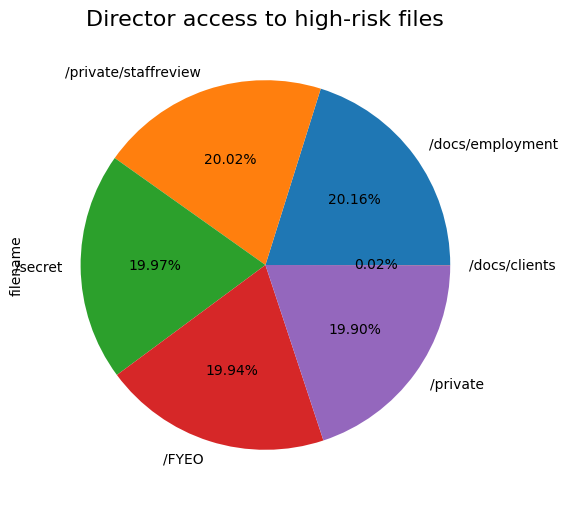

In [31]:
# splitting high risk file data into dataframe for role
director_highrisk_files = highrisk_merged_employee_file[highrisk_merged_employee_file["role"]=="Director"]

# Printing pie chart for director role
director_highrisk_files["filename"].value_counts().plot(kind="pie", autopct='%1.2f%%', figsize=(12,6))
plt.title("Director access to high-risk files", fontsize=16)

### Finance
Finance role accessed client documents and the secret file, this is expected as they would need to use and update financial documents which could be stored in both of these files.

Text(0.5, 1.0, 'Finance access to high-risk files')

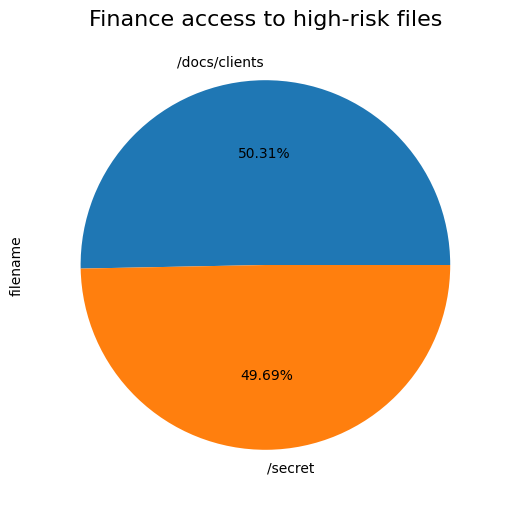

In [32]:
# splitting high risk file data into dataframe for role
finance_highrisk_files = highrisk_merged_employee_file[highrisk_merged_employee_file["role"]=="Finance"]

finance_highrisk_files["filename"].value_counts().plot(kind="pie", autopct='%1.2f%%', figsize=(10,6))
plt.title("Finance access to high-risk files", fontsize=16)

### HR
It is expected that the HR role would need access to employment documents. The contents of the secret file are relatively unknown and therefore the only assumption that can be made on this file is that it contains important data that shouldn't leave the company. HR may have access to this file but so it doesnt raise much suspicion.

Text(0.5, 1.0, 'HR access to high-risk files')

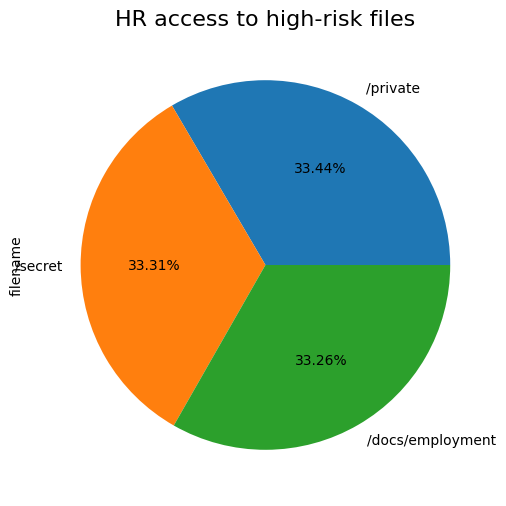

In [33]:
# splitting high risk file data into dataframe for role
HR_highrisk_files = highrisk_merged_employee_file[highrisk_merged_employee_file["role"]=="HR"]

HR_highrisk_files["filename"].value_counts().plot(kind="pie", autopct='%1.2f%%', figsize=(10,6))
plt.title("HR access to high-risk files", fontsize=16)

### Technical
Technical roles have accessed mostly expected files. Both "/dev" and "/system/source" files should be solely used for development meaning tech roles have full access. The "/security/ids" file is a security file however may need to be accessed by tech roles seldomly to change passwords, change RFID chips in access cards or fix issues with other user accounts.

Like before the contents of the "/secret" file are unknown. It is quite possible that it contains some data or files that are needed by technical roles and therefore its access raises no suspicion.

Text(0.5, 1.0, 'Technical access to high-risk files')

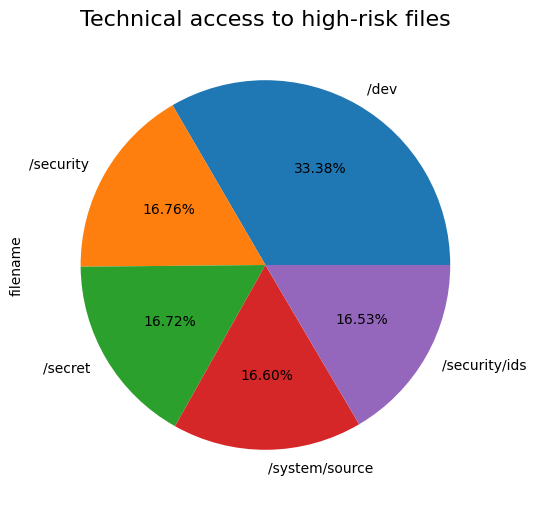

In [34]:
# splitting high risk file data into dataframe for role
technical_highrisk_files = highrisk_merged_employee_file[highrisk_merged_employee_file["role"]=="Technical"]

technical_highrisk_files["filename"].value_counts().plot(kind="pie", autopct='%1.2f%%', figsize=(10,6))
plt.title("Technical access to high-risk files", fontsize=16)

### Security
Security roles accessed expected files. The access of the "/secret" file may be considered slightly strange as one wouldn't presume it contains any data of use to the security role however without knowing the exact contents we cannot call this suspicious activity in itself. This access should be investigated further to uncover anything malicious.

Text(0.5, 1.0, 'Security access to high-risk files')

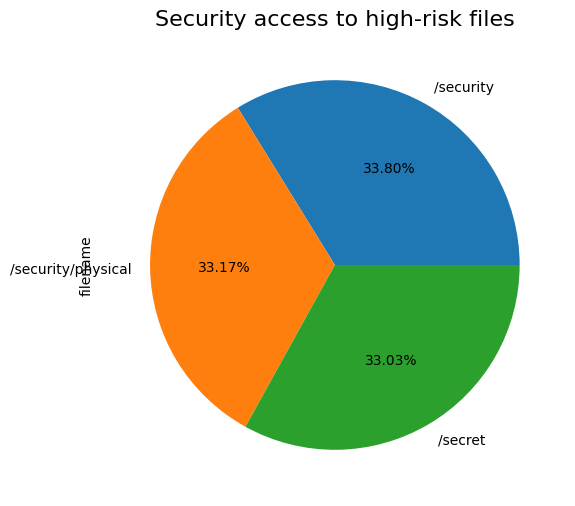

In [35]:
# splitting high risk file data into dataframe for role
security_highrisk_files = highrisk_merged_employee_file[highrisk_merged_employee_file["role"]=="Security"]

security_highrisk_files["filename"].value_counts().plot(kind="pie", autopct='%1.2f%%', figsize=(10,6))
plt.title("Security access to high-risk files", fontsize=16)

### Services
Services staff show extremely strange behaviour in terms of file access. The service staff accessed the "/secret" file and while the contents of this file are unknown they probably do not need access. Suspicious behaviour cannot be flagged from access to this file due to the fact all other roles have also accessed it and the contents are unknown.

Services staff probably consists of workers such as estates, waste management, kitchen staff and others that carry out various services for the organisation. These staff would definetly not need access to client documents which are shown to be accessed in the chart below.

Due to this suspicious activity a secondary pie chart shows access to all files from users within the services role. This shows that users within the services role are also accessing files such as "docs/committee", "/company_profile", "/system", "/policy" and "/tech". Users within this role should have no need of access to these specific files hence further investigation into this role is needed.

USB data will need to be investigated in order to explore the possibility that services staff have been making copies of client documents, this can be found below the high-risk files pie chart below.

Text(0.5, 1.0, 'Services access to high-risk files')

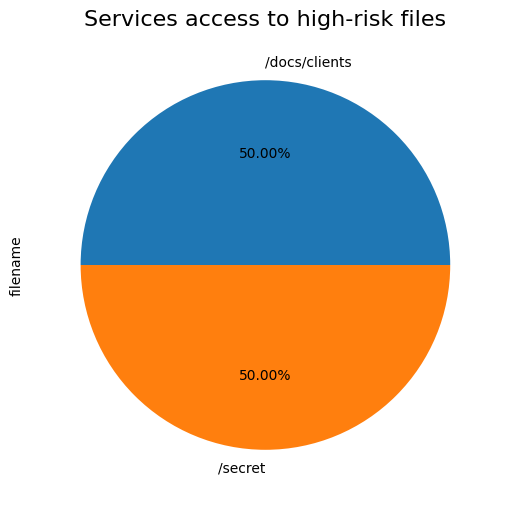

In [36]:
# splitting high risk file data into dataframe for role
services_highrisk_files = highrisk_merged_employee_file[highrisk_merged_employee_file["role"]=="Services"]

services_highrisk_files["filename"].value_counts().plot(kind="pie", autopct='%1.2f%%', figsize=(10,6))
plt.title("Services access to high-risk files", fontsize=16)

Text(0.5, 1.0, 'Services access to all files')

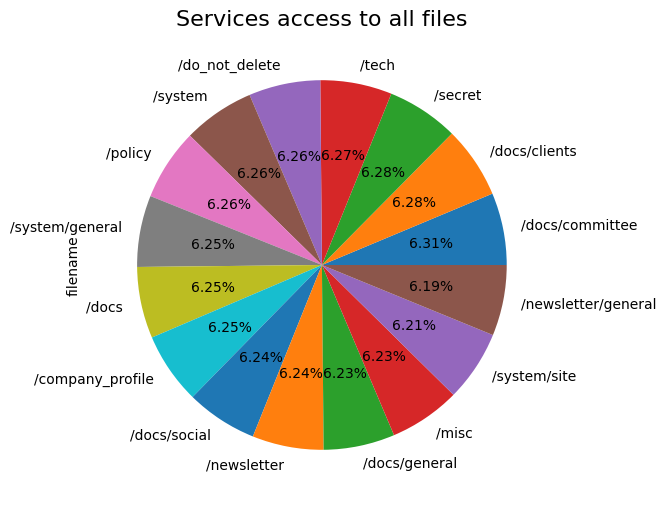

In [37]:
mef[mef["role"]=="Services"]["filename"].value_counts().plot(kind="pie", autopct='%1.2f%%', figsize=(10,6))
plt.title("Services access to all files", fontsize=16)

#### In depth analysis of USB data for services role
One of the biggest threats to the organisation would be data leaks, the suspicious behaviour above warrants investigation into USB data to ensure this is not happening. USB data will be cross-references with File data to check if USB devices, that could be used to copy files, were inserted at the time these files were accessed. If this is the case then it gives significant proof that service staff are engaged in making copies of important documents. 

This part of the investigation will first focus on the highly confidential client documents. Data leaks involving these could have extreme repercussions for the company as it would break multiple GDPR (General Data Protection Regulation) and client confidentiality laws.

In order to achieve this a new dataframe will be created holding information about file access as well as usb inserts and removal, this dataframe will be sorted chronologically. In this specific dataframe the info column will either hold the users email address or the file address depending on if it is usb or file data respectively.

In [38]:
# function to get list of possible leaked datetimes with corresponding user for a singular file
def getPosLeakList(usbs, files):
    # create list to hold temp data
    posLeakList = []

    usbs.sort_values(by="datetime") # sorting by datetimes
    
    # looping through usb groups name is each user group holds all data
    for name, group in usbs.groupby("user"):
        # looping through individual loop
        for i in range(len(group)):
            # if record is insert and next is remove retrieve access data from files dataframe with files inside both datetimes
            if group.iloc[i]["action"]=="usb_insert" and group.iloc[i+1]["action"]=="usb_remove":
                access = files[(files["user"]==name) & (files["datetime"] > group.iloc[i]["datetime"]) & (files["datetime"] < group.iloc[i+1]["datetime"])]
                # if access contains data append
                if len(access) > 0:
                    posLeakList.append(access)
    # change list to dataframe
    posLeakList_df = pd.concat(posLeakList)

    return posLeakList_df # return data

# creation of new dataframe only containing records where the client documents file was accessed by services staff, dropping unneeded data
services_highrisk_files = highrisk_merged_employee_file[highrisk_merged_employee_file["role"]=="Services"]
services_highrisk_files = services_highrisk_files[services_highrisk_files["filename"]=="/docs/clients"]


# creating new dataframe holding usb data for services role, dropping unneeded data
services_usb_data = pd.merge(usb_data, employee_data, on="user")
services_usb_data = services_usb_data[services_usb_data["role"]=="Services"]


# retrieving list of users with amount of file access inbetween usb inserts and removals
possible_leaked_files = getPosLeakList(services_usb_data, services_highrisk_files)

When plotted on a bar chart to show the amount of times each has accessed the client docs file the results are quite worrying. All users accessed the file multiple times while a USB device was inserted meaning any one of them could have possible made a copy of the file leaded to a data leak.

The following code also prints all the users that accessed the file with a USB device more than 100 times. These users raise the highest suspicion, it should be noted that the top user, "user-jok", accessed the file 115 times which breaks higher than normal in the trend, this poses a higher risk of suspicious activity.

user
usr-jok    115
usr-rvx    109
usr-okf    109
usr-tra    108
usr-evp    108
usr-mki    107
usr-jsv    106
usr-upm    105
usr-qmo    104
usr-xrb    104
usr-svz    104
usr-coz    103
Name: filename, dtype: int64


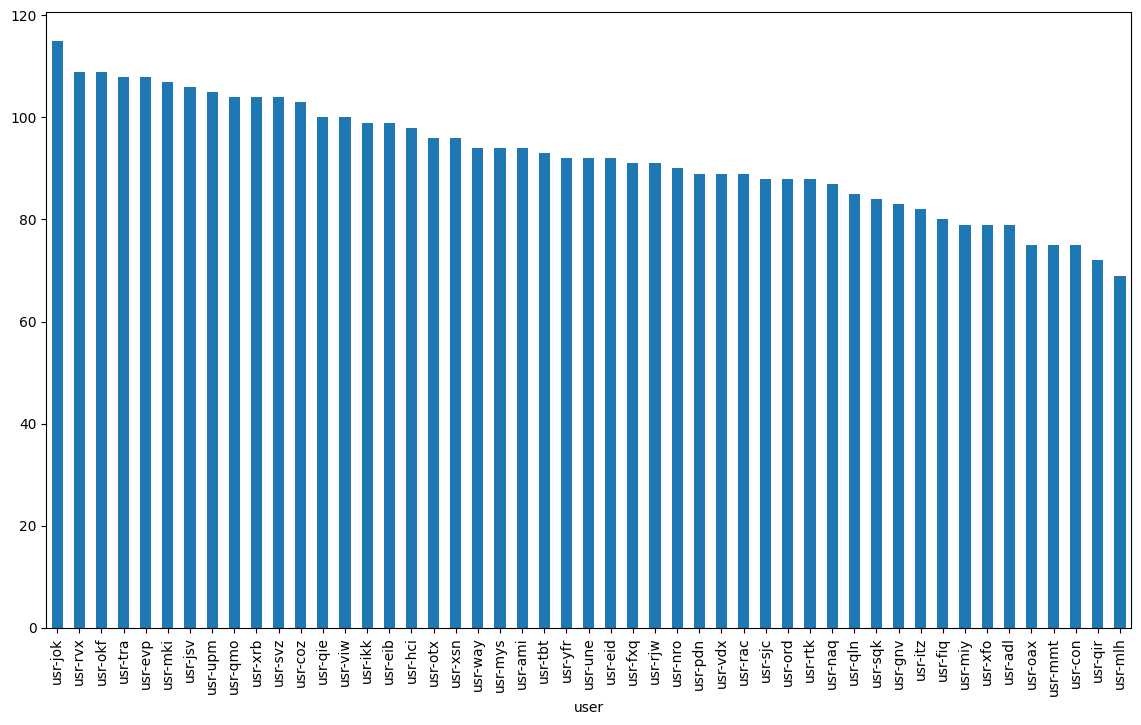

In [39]:
# printing graph showing total accesses to client docs file from all users while a USB device was inserted
possible_leaked_files_count = possible_leaked_files.groupby("user")["filename"].count().sort_values(ascending=False)
possible_leaked_files_count.plot(kind="bar", figsize=(14, 8))

print(possible_leaked_files_count[possible_leaked_files_count>100])

### Legal
Legal roles only accessed expected files these being "/secret" and "/docs/clients" the later containing client documents. Access to both these files doesn't indicate anything suspicious about users in this role.

Text(0.5, 1.0, 'Legal access to high-risk files')

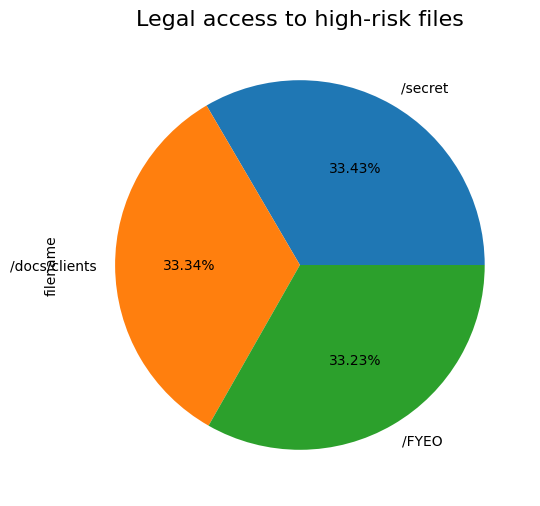

In [40]:
# splitting high risk file data into dataframe for role
legal_highrisk_files = highrisk_merged_employee_file[highrisk_merged_employee_file["role"]=="Legal"]

legal_highrisk_files["filename"].value_counts().plot(kind="pie", autopct='%1.2f%%', figsize=(10,6))
plt.title("Legal access to high-risk files", fontsize=16)

## Checking mismatched PCs
In this section PCs that USBs were inserted into will be cross-checked against allocated PCs to check if any users have performed these actions from PCs other than their own.

This check shows some users have used usb devices on PCs other than their pre-allocated one and warrant further investion. Due to the fact a mismatch in PC used and allocated PC has not been seen before in this investigation throughout the vast amount of records, this can be flagged as suspicious behaviour. The check also shows that these actions are by a singular user. The user "usr-rhd" is classified under the Director role which makes this behaviour much more serious. 

The recipient PC is allocated to user "usr-eie" classified under the Finance role.

The second dataframe conducts a count of all the users, under the Director role, using USB devices. This returns 16, hence this Director is the sole user of a USB device under this specific role. This would confirm that the use of a USB device for a Director is not normal providing overwhelming evidence that this is a case of suspicious activity.

In [41]:
# Checking merged employee_data, usb_data
meu = pd.merge(employee_data, usb_data, on="user")
print(len(meu[meu["pc_y"]!=meu["pc_x"]]))

# creating new dataframe containing mismatched pc records
mismatched_usbs = meu[meu["pc_y"]!=meu["pc_x"]]
mismatched_usbs

16


,user,role,email,pc_x,datetime,action,pc_y
278614,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-08-07 13:59:39.095515,usb_insert,pc248
278615,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-08-07 14:58:32.019707,usb_remove,pc248
278616,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-08-07 16:12:32.850255,usb_insert,pc248
278617,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-08-07 17:10:00.669627,usb_remove,pc248
278618,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-08-07 19:19:47.099527,usb_insert,pc248
278619,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-08-07 19:31:43.307955,usb_insert,pc248
278620,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-08-07 19:39:24.596043,usb_remove,pc248
278621,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-08-07 19:47:37.555743,usb_remove,pc248
278622,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-08-07 20:10:14.118667,usb_insert,pc248
278623,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-08-07 20:37:30.891533,usb_remove,pc248


In [42]:
# printing value counts of usb usage
print("\nUSB Usage for Director role: ")
print(meu[meu["role"]=="Director"]["datetime"].count())

# printing other user involved
print("\nAccessed PC: ")
print(employee_data[employee_data["pc"]=="pc248"])

# creating suspicious user list
suspicious_user_list = ["usr-rhd"]


USB Usage for Director role: 
16

Accessed PC: 
        user     role                       email     pc
248  usr-eie  Finance  usr-eie@onlinebargains.com  pc248


## Emails from suspicious user
User "usr-rhd" flagged in the last section of the investigation from a mismatch of PCs accessed with a USB device and allocated PCs in employee data. The user will be investigated first by checking suspicious email activity.

This activity occured over a range of 3 days from 07/08/2020 to 10/08/2020, in order to better check suspicious email activity for these two users email data can be filtered down to a range across these dates. It may be sensible to start looking in the previous month to the incident upto a week or 2 weeks after the incident.

The chosen date range is 25/07/20 to 15/08/20. A bar chart has been plotted showing the volume of email sent each day by this user, across the specific date range.

The bar chart plotted shows the amount of emails the user has sent on each day in chronological order. 2020-08-03 is a clear outlier and shows 

First case: 2020-08-07 13:59:39.095515
Last case: 2020-08-10 16:21:13.621977

 Average number of emails sent: 61.0


<AxesSubplot: xlabel='datetime'>

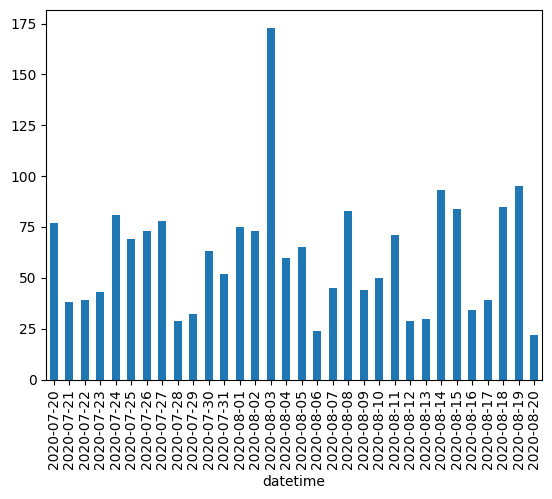

In [43]:
# printing cases of suspicious activity
print("First case: " + str(min(mismatched_usbs["datetime"])))
print("Last case: " + str(max(mismatched_usbs["datetime"])))

# creating suspicious email list from suspicious user list
suspicious_email_list = employee_data[employee_data["user"].isin(suspicious_user_list)]["email"]

# creating email dataframe for specific user
suspicious_email_df = email_data[email_data["sender"].isin(suspicious_email_list)]

# setting search daterange
daterange_start = pd.to_datetime("2020-07-20 00:00:00")
daterange_end = pd.to_datetime("2020-08-20 00:00:00")
email_search_range = pd.date_range(start=daterange_start, end=daterange_end, freq="D").date

# filter email list down to only include emails that have been sent between these dates
suspicious_email_df = suspicious_email_df[suspicious_email_df["datetime"].dt.date.isin(email_search_range)]
suspicious_email_df.drop(columns=["sender"], inplace=True)
suspicious_email_df["datetime"] = suspicious_email_df["datetime"].dt.date

# calculating amount of emails sent per day for this user
suspicious_email_count = suspicious_email_df.groupby("datetime")["recipient"].count()

# printing average value for emails sent per day
print("\n Average number of emails sent: " + str(suspicious_email_count.mean().round()))

# plotting bar chart
suspicious_email_count.plot(kind="bar")

In [44]:
# setting specific date to check
checkdate = pd.to_datetime("2020-08-03 00:00:00").date()

suspicious_email_df = suspicious_email_df[suspicious_email_df["datetime"]==checkdate]

# counting amount of emails sent to each recipient
suspicious_email_df.groupby("recipient")["datetime"].count().sort_values(ascending=False).head()

recipient
usr-xpo@onlinebargains.com    100
usr-zvn@onlinebargains.com      2
usr-jsn@onlinebargains.com      2
usr-vui@onlinebargains.com      2
usr-hzp@onlinebargains.com      2
Name: datetime, dtype: int64

## Forming links between suspicious users
Currently the Director "usr-rhd" sent 100 emails on the 03-08-2020 to HR user "usr-xpo". This was 4 days before, on the 07-08-2020, usr-rhd used a USB device on a finance staff member "usr-eie"'s allocated PC. The PC was accessed 6 times between the times 13:59:39 and 21:57:18. The director, usr-rhd, then used a USB device again on 10-08-2020 twice with access and removal times being: 08:37:29, 08:49:16 and 16:17:03, 16:21:13.

This behaviour is very suspicious and may confirm malicious activity. In order form a clear picture of the situation the all three users must be investigated futher. Data spotlights for each user are shown below with graphs for all data across the time period.

All graphs below are colour coded by the amount of suspicion they raise. Green being now suspicious data, orange being slight suspicion and red meaning obvious suspicious activity present.

### usr-eie (Finance)

Usr-eie has not shown any signs of being suspicious and is only involved with this investigation as their allocated PC was accessed. Below are a few value counts showing the highest five values of each metric across the whole dataset, in order to find abnormalities.

The search concluded that usr-eie is not engaged in any suspicious activity and can therefore be omitted from further investigations.

In [45]:
# file data
print("USR-EIE")

print("\nFiles Accessed")
eie_file_data = file_data[file_data["user"]=="usr-eie"]
print(eie_file_data["filename"].value_counts().head())

# login data
print("\nTotal Logins: ")
eie_login_data = login_data[login_data["user"]=="usr-eie"]
eie_login_data["datetime"] = eie_login_data["datetime"].dt.date
print(eie_login_data.groupby("datetime").count().head())

# web data
print("\nWebsites Accessed:")
eie_web_data = web_data[web_data["user"]=="usr-eie"]
print(eie_web_data["website"].value_counts().head())

# usb data
print("\nUSB Usage")
eie_usb_data = usb_data[usb_data["user"]=="usr-eie"]
print(eie_usb_data["action"].value_counts())

# emails sent
print("\nEmails Sent:")
eie_email_data = email_data[email_data["sender"]=="usr-eie@onlinebargains.com"]
print(eie_email_data["recipient"].value_counts().head())

# emails received
print("\nEmails Received:")
eie_email_data = email_data[email_data["recipient"]=="usr-eie@onlinebargains.com"]
print(eie_email_data["sender"].value_counts().head())

USR-EIE

Files Accessed
/docs/clients       1213
/misc               1210
/company_profile    1190
/newsletter         1189
/policy             1181
Name: filename, dtype: int64

Total Logins: 
            user  action  pc
datetime                    
2020-01-01     2       2   2
2020-01-02     2       2   2
2020-01-03     2       2   2
2020-01-04     2       2   2
2020-01-05     2       2   2

Websites Accessed:
http://www.facebook.com           213
http://www.accuweather.com        208
http://www.cateringcompany.com    208
http://www.financesystem.com      205
http://www.nifty.com              204
Name: website, dtype: int64

USB Usage
Series([], Name: action, dtype: int64)

Emails Sent:
usr-gyk@onlinebargains.com    194
usr-gro@onlinebargains.com    193
usr-qcf@onlinebargains.com    189
usr-uby@onlinebargains.com    177
usr-xkb@onlinebargains.com    177
Name: recipient, dtype: int64

Emails Received:
usr-gxp@onlinebargains.com    224
usr-zbl@onlinebargains.com    223
usr-tzt@onlineb

In [46]:
# Logins on the days of USB access to PC
# 07-08
check1 = pd.to_datetime("2020-08-07 00:00:00").date()
eie_login_data1 = login_data[(login_data["datetime"].dt.date == check1) & (login_data["user"] == "usr-eie")]
print(eie_login_data1)

# 10-08
check2 = pd.to_datetime("2020-08-10 00:00:00").date()
eie_login_data2 = login_data[(login_data["datetime"].dt.date == check2) & (login_data["user"] == "usr-eie")]
print(eie_login_data2)


                  datetime     user  action     pc
109206 2020-08-07 08:40:20  usr-eie   login  pc248
109339 2020-08-07 15:34:15  usr-eie  logoff  pc248
                  datetime     user  action     pc
110692 2020-08-10 08:09:33  usr-eie   login  pc248
110857 2020-08-10 16:09:44  usr-eie  logoff  pc248


### usr-xpo (HR)

The graphs below show no suspicious activity from usr-xpo. All file, web, usb and login data shows no anomalies and is within normal values. The didnt send any emails within this period. The graphs do show an anomaly on emails recieved however these are sent from usr-rhd investigated below this section.

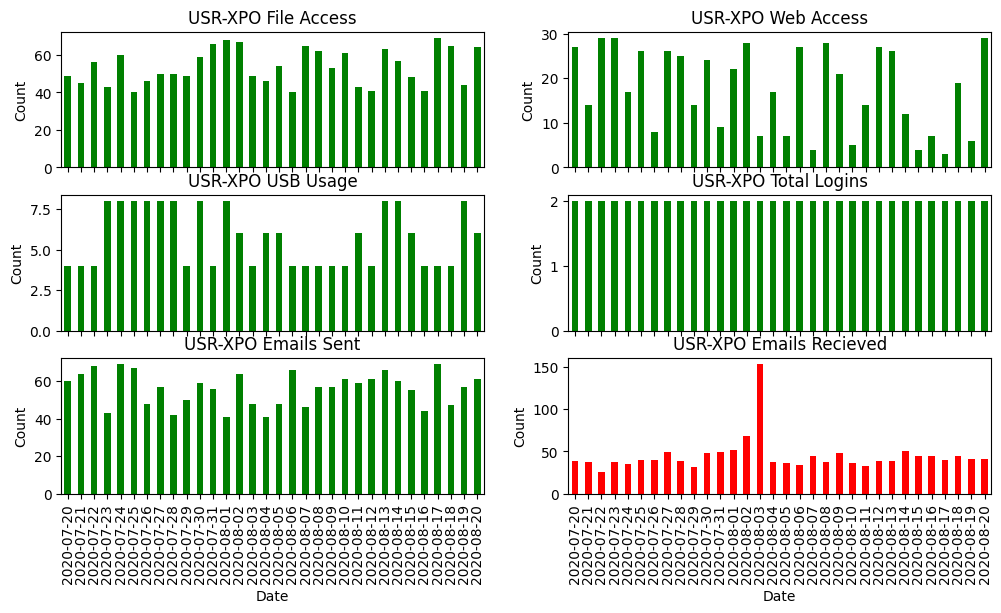

In [47]:
# creating subplot setting titles
fig, axs = plt.subplots(3,2)
axs[0,0].set_title("USR-XPO File Access")
axs[0,1].set_title("USR-XPO Web Access")
axs[1,0].set_title("USR-XPO USB Usage")
axs[1,1].set_title("USR-XPO Total Logins")
axs[2,0].set_title("USR-XPO Emails Sent")
axs[2,1].set_title("USR-XPO Emails Recieved")

# file_data
xpo_file_data = file_data[file_data["user"]=="usr-xpo"]
xpo_file_data["datetime"] = xpo_file_data["datetime"].dt.date
xpo_file_data = xpo_file_data[xpo_file_data["datetime"].isin(email_search_range)]
xpo_file_data.groupby("datetime")["filename"].count().plot(kind="bar", color="green", figsize=(12,6), ax=axs[0,0],sharex=True, sharey=False)

# web_data
xpo_web_data = web_data[web_data["user"]=="usr-xpo"]
xpo_web_data["datetime"] = xpo_web_data["datetime"].dt.date
xpo_web_data = xpo_web_data[xpo_web_data["datetime"].isin(email_search_range)]
xpo_web_data.groupby("datetime")["website"].count().plot(kind="bar", color="green", figsize=(12,6), ax=axs[0,1],sharex=True, sharey=False)

# usb_data
xpo_usb_data = usb_data[usb_data["user"]=="usr-xpo"]
xpo_usb_data["datetime"] = xpo_usb_data["datetime"].dt.date
xpo_usb_data = xpo_usb_data[xpo_usb_data["datetime"].isin(email_search_range)]
xpo_usb_data.groupby("datetime")["action"].count().plot(kind="bar", color="green", figsize=(12,6), ax=axs[1,0],sharex=True, sharey=False)

# login_data
xpo_login_data = login_data[login_data["user"]=="usr-xpo"]
xpo_login_data["datetime"] = xpo_login_data["datetime"].dt.date
xpo_login_data = xpo_login_data[xpo_login_data["datetime"].isin(email_search_range)]
xpo_login_data.groupby("datetime")["action"].count().plot(kind="bar", color="green", figsize=(12,6), ax=axs[1,1],sharex=True, sharey=False)

# email_data sent
xpo_email_data = email_data[email_data["sender"]=="usr-xpo@onlinebargains.com"]
xpo_email_data["datetime"] = xpo_email_data["datetime"].dt.date
xpo_email_data = xpo_email_data[xpo_email_data["datetime"].isin(email_search_range)]
xpo_email_data.groupby("datetime")["recipient"].count().plot(kind="bar", color="green", figsize=(12,6), ax=axs[2,0],sharex=True, sharey=False)

# email_data recieved
xpo_email_data = email_data[email_data["recipient"]=="usr-xpo@onlinebargains.com"]
xpo_email_data["datetime"] = xpo_email_data["datetime"].dt.date
xpo_email_data = xpo_email_data[xpo_email_data["datetime"].isin(email_search_range)]
xpo_email_data.groupby("datetime")["sender"].count().plot(kind="bar", color="red", figsize=(12,6), ax=axs[2,1],sharex=True, sharey=False)

for ax in axs.flat:
    ax.set(xlabel="Date", ylabel="Count")


### usr-rhd (Director)
The following charts show overwhelming proof that the user "usr-rhd" (Director) is acting maliciously.

The charts show the USB usage previously found on 07-08-2020 and 10-08-2020 and also the excessive amount of emails, previously found, sent to usr-xpo.

The charts show new suspicious activity in file and web data. A count of all the different files that usr-rhd accessed on 07-08-2020 (the date of the first suspicious USB activity) shows they accessed "/docs/employment" 54 times in one day. This breaks mean values by a great amount and should therefore be classed as suspicious.

On the web data chart an anomaly occurs on 10-08-2020 this is the last day of the suspicious USB activity. When a value counts is conducted on this data it shows that usr-rhd visited www.legaleagle.com and www.linkedin.com 5 times each, this could help to build a story of the users suspicious activity. Other websites visited include www.sky.com and www.microsoft.com, both visited once, however nothing can be inferred from these.

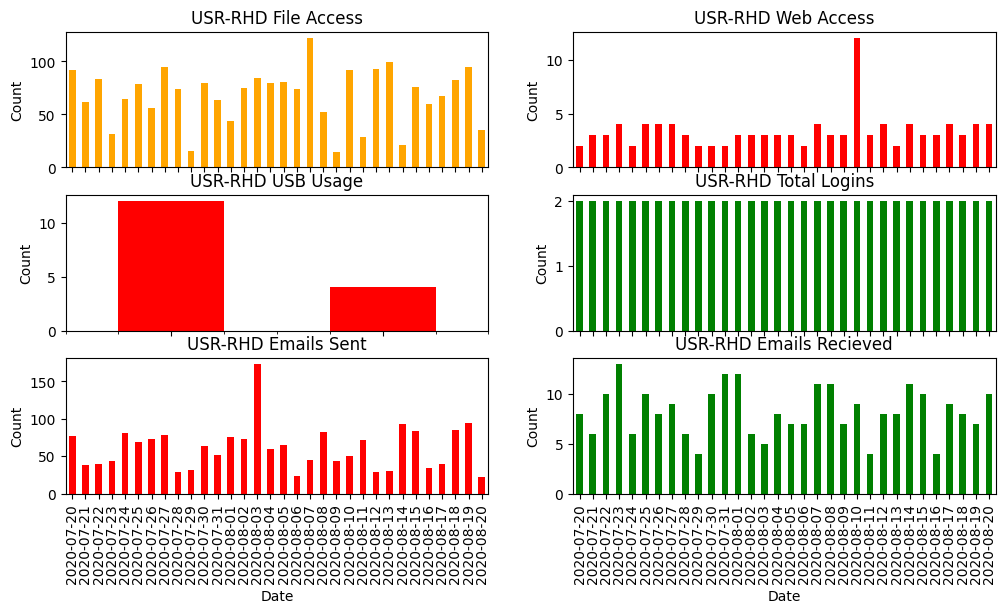

In [48]:
# creating subplot setting titles
fig, axs = plt.subplots(3,2)
axs[0,0].set_title("USR-RHD File Access")
axs[0,1].set_title("USR-RHD Web Access")
axs[1,0].set_title("USR-RHD USB Usage")
axs[1,1].set_title("USR-RHD Total Logins")
axs[2,0].set_title("USR-RHD Emails Sent")
axs[2,1].set_title("USR-RHD Emails Recieved")

# file_data
rhd_file_data = file_data[file_data["user"]=="usr-rhd"]
rhd_file_data["datetime"] = rhd_file_data["datetime"].dt.date
rhd_file_data = rhd_file_data[rhd_file_data["datetime"].isin(email_search_range)]
rhd_file_data.groupby("datetime")["filename"].count().plot(kind="bar", color="orange", figsize=(12,6), ax=axs[0,0],sharex=True, sharey=False)

# web_data
rhd_web_data = web_data[web_data["user"]=="usr-rhd"]
rhd_web_data["datetime"] = rhd_web_data["datetime"].dt.date
rhd_web_data = rhd_web_data[rhd_web_data["datetime"].isin(email_search_range)]
rhd_web_data.groupby("datetime")["website"].count().plot(kind="bar", color="red", figsize=(12,6), ax=axs[0,1],sharex=True, sharey=False)

# usb_data
rhd_usb_data = usb_data[usb_data["user"]=="usr-rhd"]
rhd_usb_data["datetime"] = rhd_usb_data["datetime"].dt.date
rhd_usb_data = rhd_usb_data[rhd_usb_data["datetime"].isin(email_search_range)]
rhd_usb_data.groupby("datetime")["action"].count().plot(kind="bar", color="red", figsize=(12,6), ax=axs[1,0],sharex=True, sharey=False)

# login_data
rhd_login_data = login_data[login_data["user"]=="usr-rhd"]
rhd_login_data["datetime"] = rhd_login_data["datetime"].dt.date
rhd_login_data = rhd_login_data[rhd_login_data["datetime"].isin(email_search_range)]
rhd_login_data.groupby("datetime")["action"].count().plot(kind="bar", color="green", figsize=(12,6), ax=axs[1,1],sharex=True, sharey=False)

# email_data sent
rhd_email_data = email_data[email_data["sender"]=="usr-rhd@onlinebargains.com"]
rhd_email_data["datetime"] = rhd_email_data["datetime"].dt.date
rhd_email_data = rhd_email_data[rhd_email_data["datetime"].isin(email_search_range)]
rhd_email_data.groupby("datetime")["recipient"].count().plot(kind="bar", color="red", figsize=(12,6), ax=axs[2,0],sharex=True, sharey=False)

# email_data recieved
rhd_email_data = email_data[email_data["recipient"]=="usr-rhd@onlinebargains.com"]
rhd_email_data["datetime"] = rhd_email_data["datetime"].dt.date
rhd_email_data = rhd_email_data[rhd_email_data["datetime"].isin(email_search_range)]
rhd_email_data.groupby("datetime")["sender"].count().plot(kind="bar", color="green", figsize=(12,6), ax=axs[2,1],sharex=True, sharey=False)

for ax in axs.flat:
    ax.set(xlabel="Date", ylabel="Count")

In [49]:
checkdate = pd.to_datetime("2020-08-07 00:00:00").date()
print(rhd_file_data[rhd_file_data["filename"]=="/docs/employment"])
rhd_file_data = file_data[(file_data["datetime"].dt.date==checkdate) & (file_data["user"]=="usr-rhd")]
rhd_file_data["filename"].value_counts().head()

           datetime     user          filename
2282831  2020-07-20  usr-rhd  /docs/employment
2283702  2020-07-20  usr-rhd  /docs/employment
2286006  2020-07-20  usr-rhd  /docs/employment
2292006  2020-07-20  usr-rhd  /docs/employment
2292151  2020-07-20  usr-rhd  /docs/employment
...             ...      ...               ...
2625987  2020-08-19  usr-rhd  /docs/employment
2629953  2020-08-19  usr-rhd  /docs/employment
2630719  2020-08-19  usr-rhd  /docs/employment
2631681  2020-08-19  usr-rhd  /docs/employment
2632084  2020-08-20  usr-rhd  /docs/employment

[165 rows x 3 columns]


/docs/employment    54
/newsletter         10
/misc                8
/docs/committee      7
/company_profile     7
Name: filename, dtype: int64

In [50]:
checkdate = pd.to_datetime("2020-08-10 00:00:00").date()

rhd_web_data = web_data[(web_data["datetime"].dt.date==checkdate) & (web_data["user"]=="usr-rhd")]
print(rhd_web_data)
rhd_web_data["website"].value_counts()

                         datetime     user                    website
910816 2020-08-10 04:06:46.274097  usr-rhd  http://www.legaleagle.com
910817 2020-08-10 04:16:58.412490  usr-rhd  http://www.legaleagle.com
910839 2020-08-10 05:05:36.455649  usr-rhd  http://www.legaleagle.com
911033 2020-08-10 06:46:26.949499  usr-rhd    http://www.linkedin.com
911042 2020-08-10 06:49:05.336062  usr-rhd  http://www.legaleagle.com
911189 2020-08-10 07:35:23.600324  usr-rhd    http://www.linkedin.com
911748 2020-08-10 09:49:01.316939  usr-rhd    http://www.linkedin.com
912041 2020-08-10 10:30:59.392632  usr-rhd  http://www.legaleagle.com
912361 2020-08-10 11:18:29.229360  usr-rhd         http://www.sky.com
912552 2020-08-10 11:48:44.039248  usr-rhd   http://www.microsoft.com
914816 2020-08-10 19:45:11.694477  usr-rhd    http://www.linkedin.com
914927 2020-08-10 20:43:55.561976  usr-rhd    http://www.linkedin.com


http://www.legaleagle.com    5
http://www.linkedin.com      5
http://www.sky.com           1
http://www.microsoft.com     1
Name: website, dtype: int64

# Investigating Web Data
Although the previous investigation deals with web data in a microcosmic sense, there have been no general investigations of the web data csv. This section will look through some general visualisations of the data to check if any more suspicious behaviour can be found.

The chart below shows that there are no specific website which show suspicious traffic from employees. This activity can better be detected when web data is split by user and then plotted, shown in the role dedicated sections following.

<AxesSubplot: >

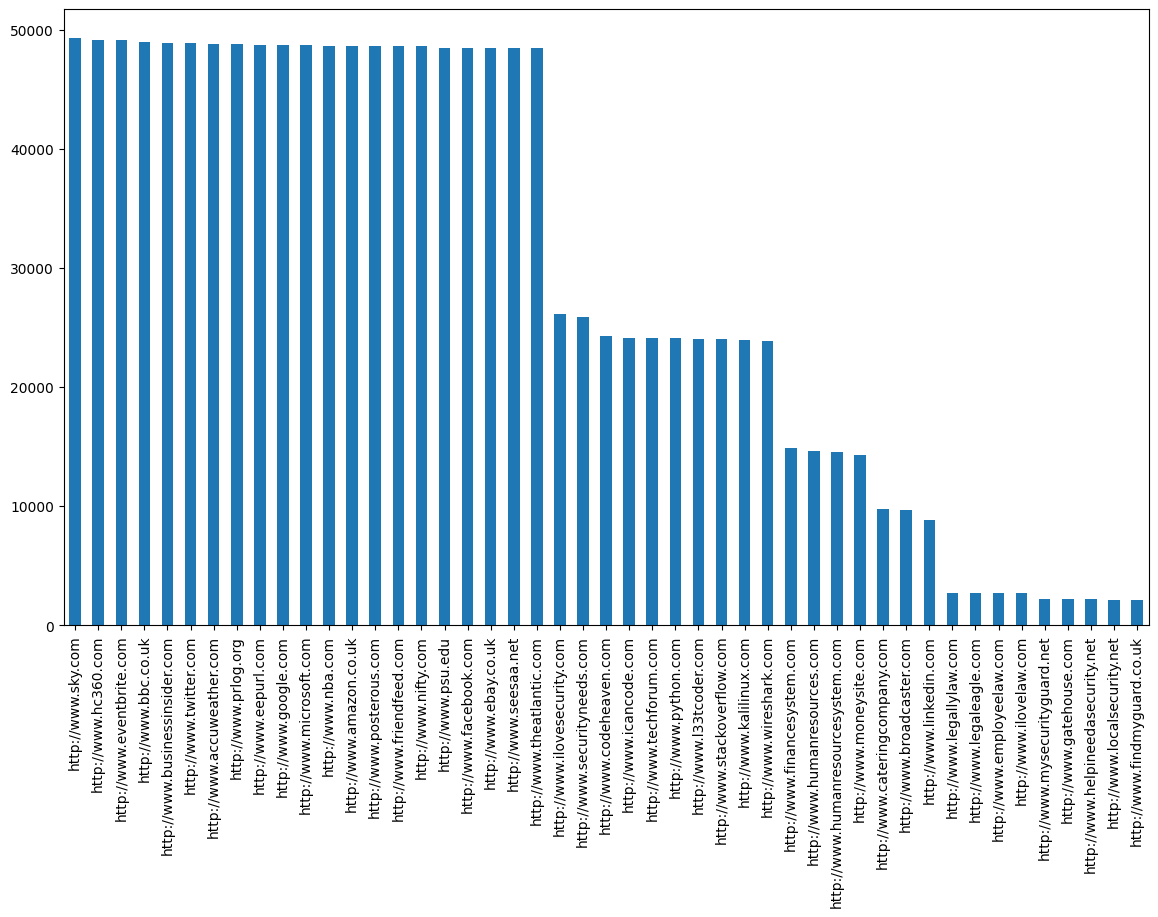

In [51]:
# show access amounts for each website
web_data["website"].value_counts().plot(kind="bar", figsize=(14,8))

In [52]:
# create merged frame
mew = pd.merge(web_data, employee_data, on="user")

# splitting web data by role
director_web_data = mew[mew["role"]=="Director"]
finance_web_data = mew[mew["role"]=="Finance"]
HR_web_data = mew[mew["role"]=="HR"]
technical_web_data = mew[mew["role"]=="Technical"]
security_web_data = mew[mew["role"]=="Security"]
services_web_data = mew[mew["role"]=="Services"]
legal_web_data = mew[mew["role"]=="Legal"]

## Director/Finance
The director web traffic chart does show that "www.legaleagle.com" and "www.linkedin.com" are visited a minuscule amount of time relative to the other websites. This could link back with the suspicious activity previously found about usr-rhd as these are two of the websites they visited that flagged as abnormal. In order to confirm this hypothesis a count of the amount of visits is shown below the chart.

The value check on these two sites confirms that usr-rhd was the only director to access either of the sites accross the whole dataset. This doesn't conform to the normal activity of the other director and therefore confirms accusations that this user is acting maliciously.

The finance chart shows no suspicious activity.

<AxesSubplot: title={'center': 'Finance Web Access'}>

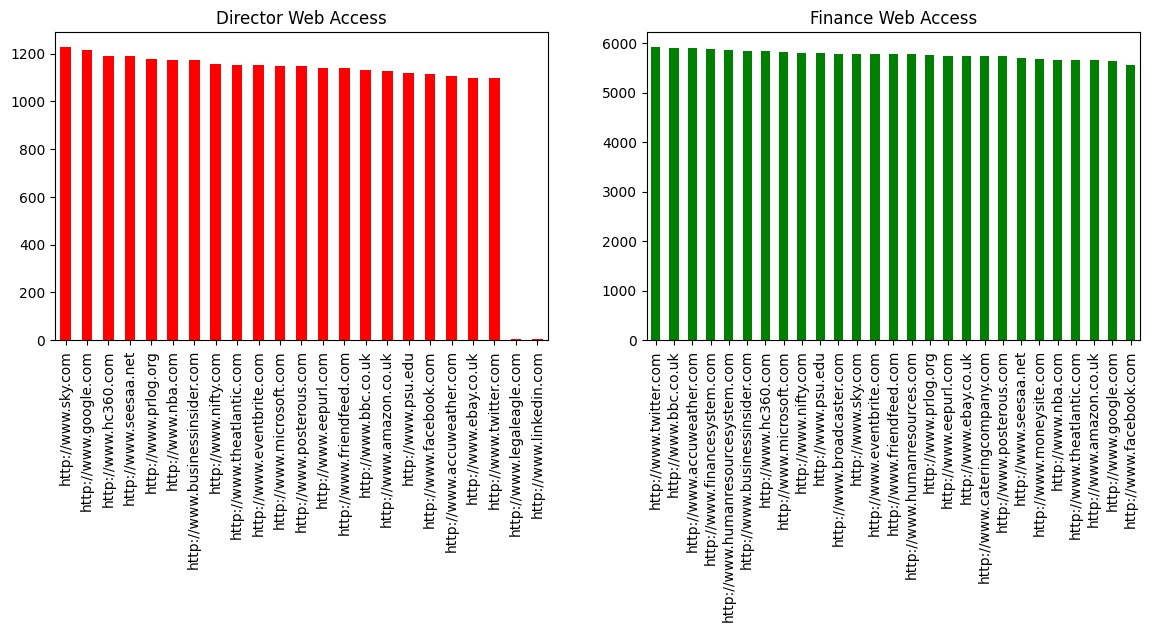

In [53]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title("Director Web Access")
axs[1].set_title("Finance Web Access")

# plotting value counts for websites visited by each role
director_web_data["website"].value_counts().plot(kind="bar", ax=axs[0], figsize=(14,4), color="red")
finance_web_data["website"].value_counts().plot(kind="bar", ax=axs[1], figsize=(14,4), color="green")

In [54]:
suspicious_sites = ["http://www.legaleagle.com", "http://www.linkedin.com"] # adding suspicious sites

# remaking dataframe containing only data from these sites
director_web_data = director_web_data[director_web_data["website"].isin(suspicious_sites)]
print(director_web_data["website"].value_counts())

http://www.legaleagle.com    5
http://www.linkedin.com      5
Name: website, dtype: int64


## HR/Technical

HR and Technical roles show no suspicious activity. The websites: "www.kalilinux.com" and "www.wireshark.com" were accessed. Kalilinux is a penetration testing software marketted as ethical hacking software, of course it is entirely possible that a user can use it unethically .Wireshark is a packet sniffer allowing users to see protocols and connections accross their network.

Due to the fact that all technical users have accessed both of these websites then they are probably being used ethically. The fact they are accessed by the technical role also suggests they are being used to test the organisations systems.

<AxesSubplot: title={'center': 'Technical Web Access'}>

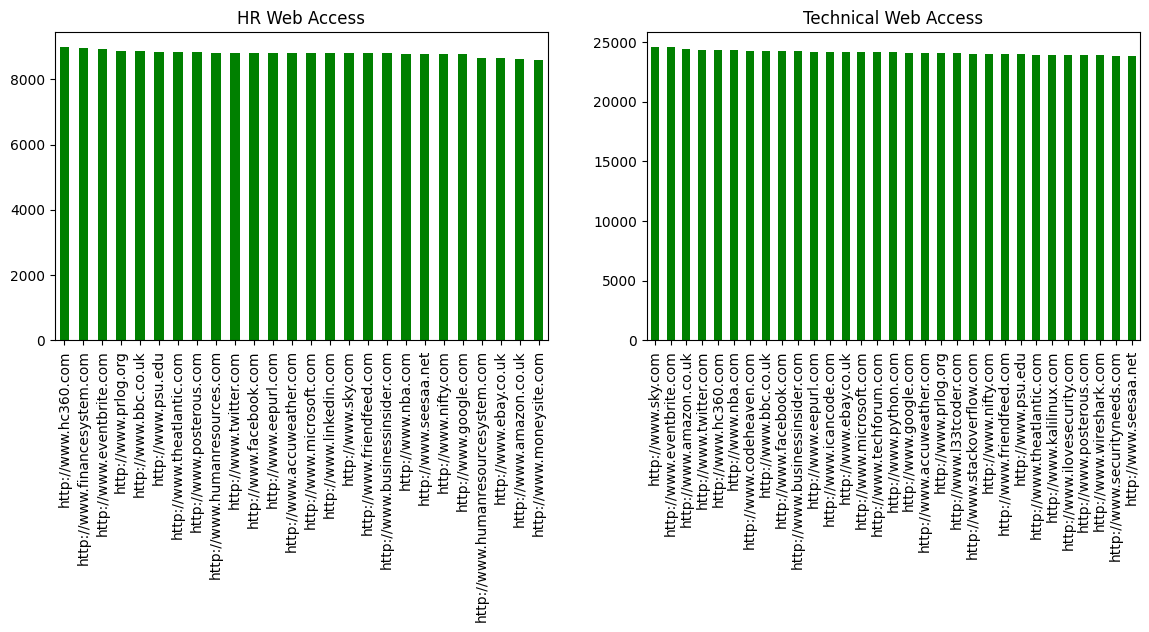

In [55]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title("HR Web Access")
axs[1].set_title("Technical Web Access")

# plotting value counts for websites visited by each role
HR_web_data["website"].value_counts().plot(kind="bar", ax=axs[0], figsize=(14,4), color="green")
technical_web_data["website"].value_counts().plot(kind="bar", ax=axs[1], figsize=(14,4), color="green")

## Security/Services
Security and Services staff show no suspicious behaviour.

<AxesSubplot: title={'center': 'Services Web Access'}>

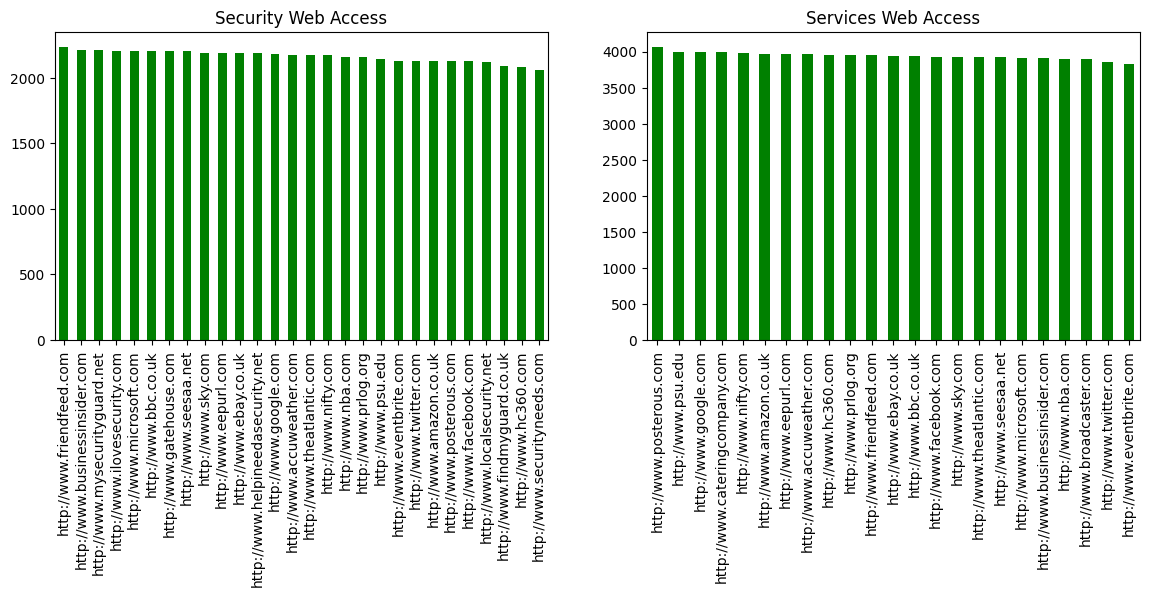

In [56]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title("Security Web Access")
axs[1].set_title("Services Web Access")

# plotting value counts for websites visited by each role
security_web_data["website"].value_counts().plot(kind="bar", ax=axs[0], figsize=(14,4), color="green")
services_web_data["website"].value_counts().plot(kind="bar", ax=axs[1], figsize=(14,4), color="green")

## Legal
Web data for the Legal role is all within expected ranges and no anomalies are shown.

Text(0.5, 1.0, 'Legal Web Access')

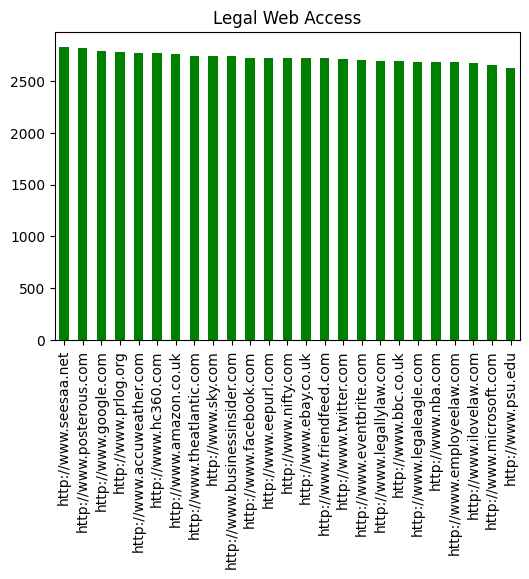

In [57]:
legal_web_data["website"].value_counts().plot(kind="bar", figsize=(6,4), color="green")
plt.title("Legal Web Access")

# Conclusion - Summary of Findings

## Activity Description
The director usr-rhd used a USB device on PC-248, allocated to usr-eie (Finance), 6 times (6 inserts, 6 removals) between the hours 13:59 and 21:57 on Friday the 7th of August 2020. This PC was then accessed again at 8:37-8:49 and 16:17-16:21 on the Monday the 10th of August, 2020.

The director usr-rhd showed suspicious email activity on Monday the 3rd of August 2020 where they sent 100 emails to the corresponding email of usr-xpo, a staff member in HR. This caused a massive anomaly with the next highest amount of emails being 2.

The director also elicited suspicious file access amounts with "/docs/employment", probably containing documents details contracts and employments, being accessed 54 times on Friday the 7th of August, 2020, which happens to be the same day the first USB usage was detected.

Lastly further searches of web data highlighted some questionable activity from this user in terms of web access. The director accessed the websites: "http://www.legaleagle.com" and "http://www.linkedin.com" a total sum of 10 times, 5 each, on Monday the 10th of August, 2020. This web activity would usually be within the normal range and not an anomaly, however, over the 6 month period usr-rhd is the only director to ever access either one of these websites which causes this case to be an outlier.

## Possible Conclusions
There are multiple possible scenarios which could lead on from what the data has shown. none of the evidence is consequential enough to tell the whole story and allow for full certainty on what happened. Some probable insights into why different actions took place are detailed below:

 - Chronologically, the first event occured when director usr-rhd sent 100 emails to HR usr-xpo in one day. This is detailed in the user spotlights. This activity does suggest that usr-xpo was involved in this suspicious activity in some way. A user specific search did not find anything out of the ordinary for this user and therefore no conclusions can be made from this email data.
 
 - The next events happened on 07-08-2020. These included multiple files accesses to employment documents, starting at 11:55am and continuing most of the day till around 22:08. The director also proceeded to gain access to PC-248, belonging to usr-eie, throughout the whole day, with the first access being at 13:59 and the last being 21:57. The first access with the USB drive occured while usr-eie was logged onto the computer meaning it was probably done during a lunch break. On that day, the login time for usr-eie was 08:40 and the logoff time was 15:34, this means that the last 5 USB accesses of that day occured after the user had left, hinting at the fact this may have been pre-meditated.

 - The last set of activity occured on 10-08-2020. This day saw the director access multiple websites a large amount of times and also gain access to PC-248 again using a USB device. The director accessed www.legaleagle.com four times from 04:06 to 07:35 and www.linkedin.com once at 06:49, all detailed in user spotlights. After this usr-rhd gained access with a USB device to PC-248 at 08:37, removing it at 08:49, this is particularly strange as usr-eie was currently logged into the pc, with their login time being 08:09, meaning they must have been away from their desk for this to happen. The finance employee, usr-eie, logged off pc-248 at 16:09 the same day after which the director gained access a second time with a USB device, at 16:17 with removal time being 16:21. During the time inbetween usr-rhd accessed www.linkedin.com a further four times and www.legaleagle.com once between 09:49 and 20:43. This web activity may suggest that usr-rhd was looking for legal advice or alternate jobs as they thought there was a chance they might get fired, further solidifing the fact that the usb activity was malicious.

 - The purpose of this activity is unknown however the classification of it being malicious is almost certain. The second USB access was probably to install some kind of spyware or keyloggger due to the fact the director went back to the pc after the other user had logged off. If this was the case usr-rhd would have access to everything usr-eie used that day such as accounts, websites, files and anything else needing a password. 

## Overview
A plethora of data has been explored in this investigation. General searches were conducted through all provided csvs followed by more specialised ones to put certain data on a smaller scale allowing anomalies to be more easily detected. Most data was inconsequential and showed a normal trend spanning throughout most users and roles.

The first search including login data and duration of time logged in outside working hours. This did show that the services department had an extreme amount of time logged in however no users were anomalous and all followed the same sort of trend. Nothing could be concluded from this data. Tracked file accesses across the services role also uncovered some strange activity but, as before, there was no concrete evidence showing any malicious activity.

The goal of the investigation was to find a user who had been ingaging in suspicious acitivty, present the data that suggests they are doing so and then solidify this hypothesis with further data visualisations and proofs. The user determined to be acting maliciously was "usr-rhd" a Director that had very suspicious activity across a number of data types.